<a href="https://colab.research.google.com/github/mikislin/CNE25/blob/main/notebooks/CNE_Class3_QAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## perform YOLO11 pose estimation using your webcam

In [ ]:
!uv pip install opencv-python-headless

In [ ]:
!uv pip install ultralytics
import ultralytics
ultralytics.checks()

YOLO (You Only Look Once), a popular object detection and image segmentation model, was developed by Joseph Redmon and Ali Farhadi at the University of Washington

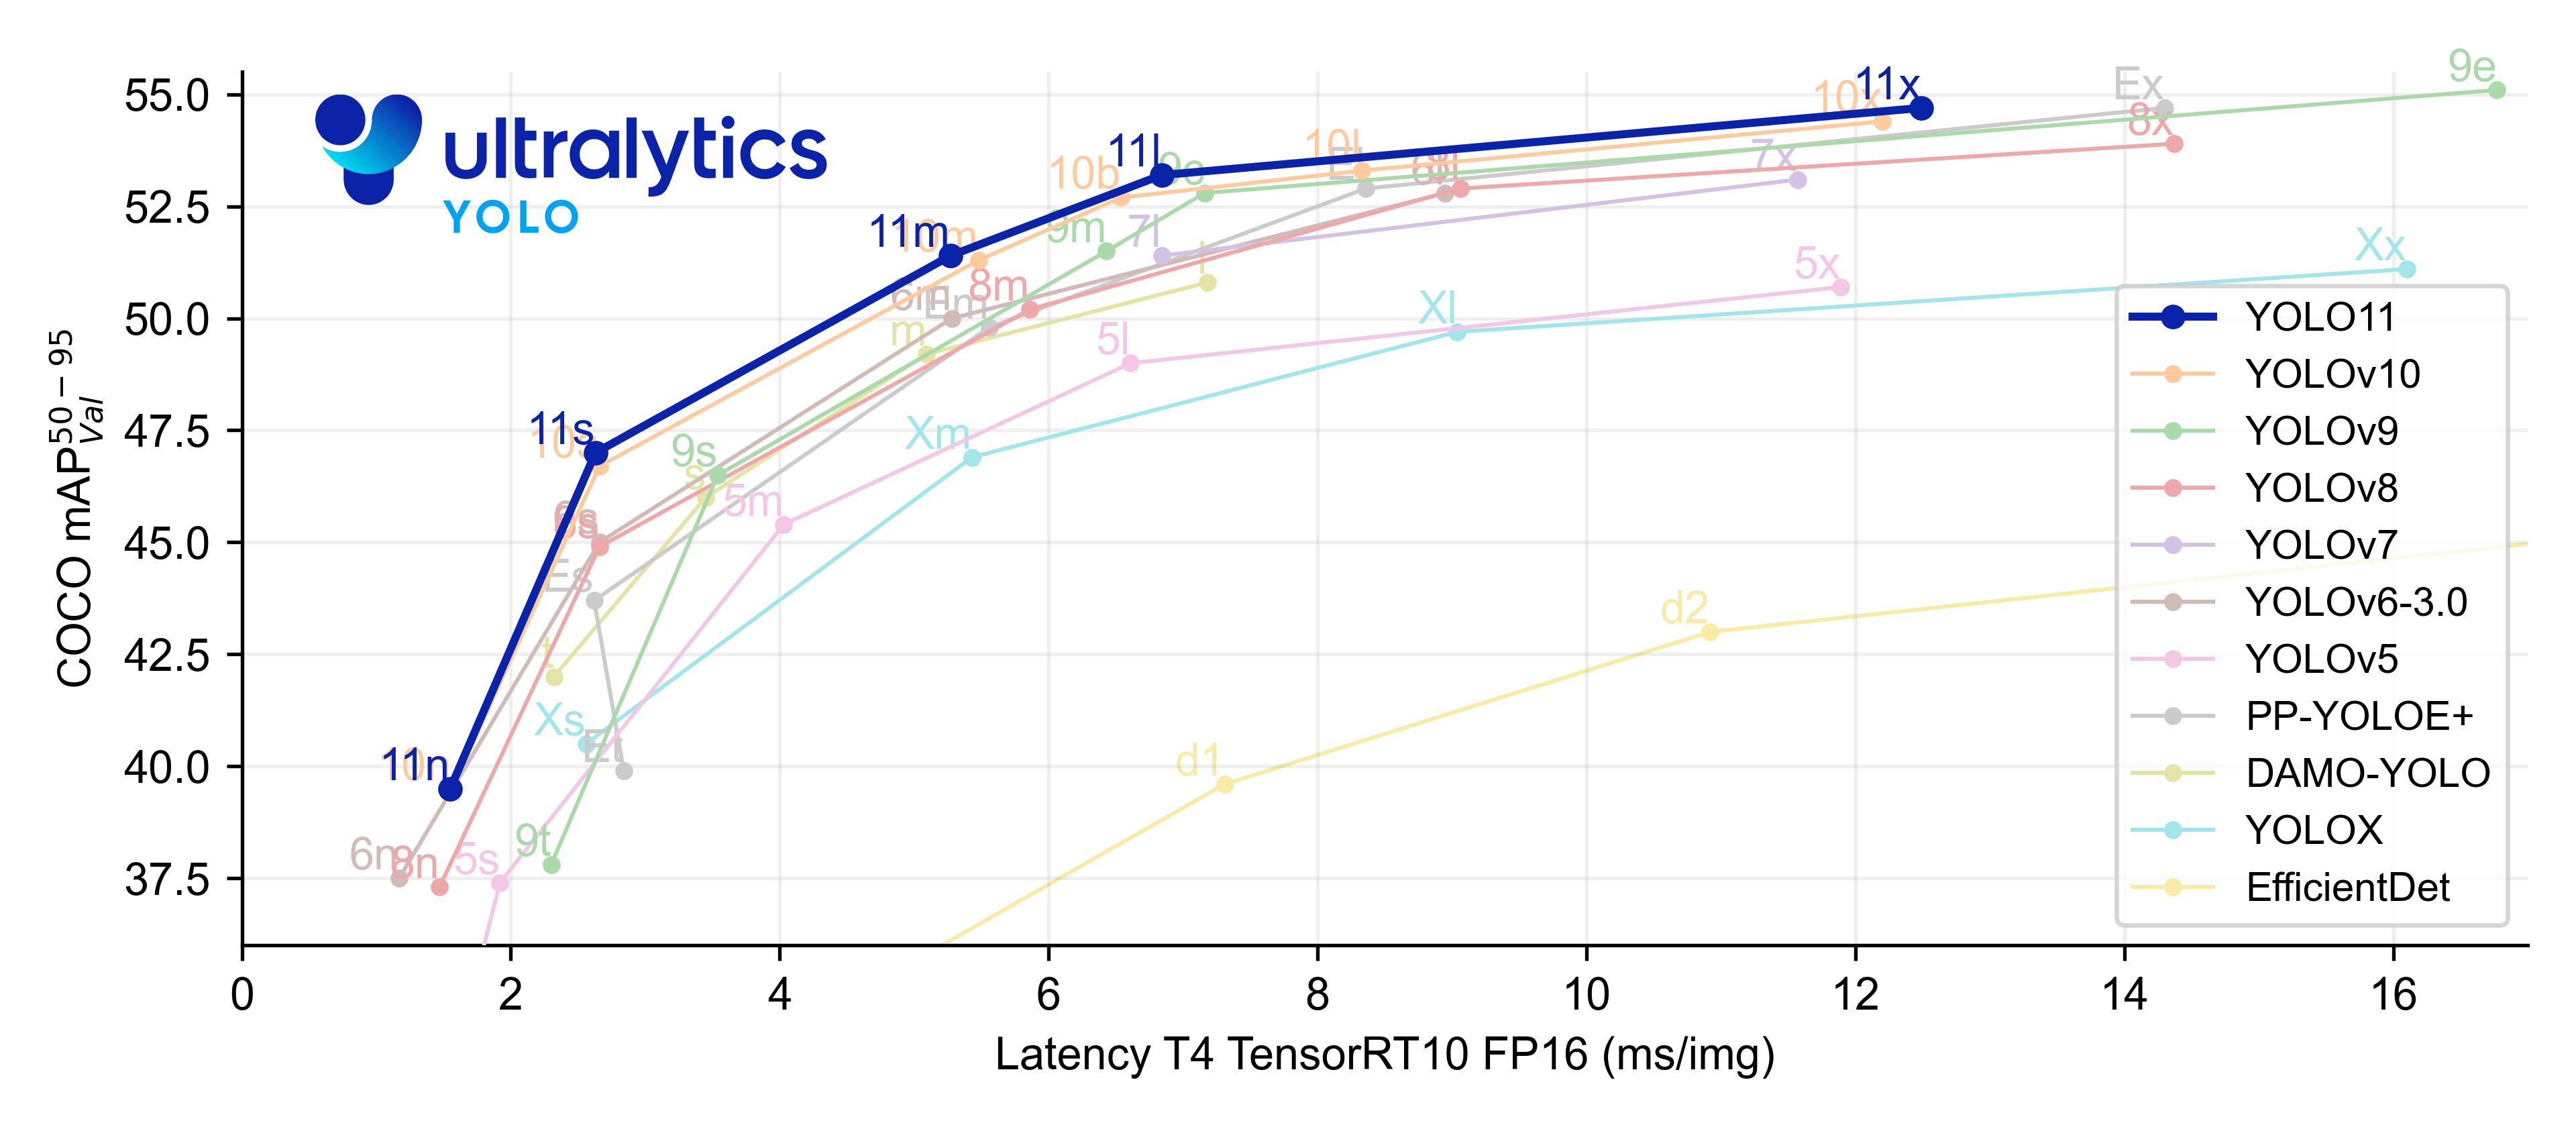

In [ ]:
# @title Load YOLO11n-pose
from ultralytics import YOLO

model = YOLO('yolo11n-pose.pt')  # load a pretrained YOLO pose model


### Define the Webcam Capture Function

This uses JavaScript to access your webcam and capture a frame when you click the button.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

### Run the Pose Estimation Loop

Run this cell to start capturing and processing. Click "Capture" to take a frame, process it with YOLO11 for pose estimation, and display the output. Repeat as needed. Interrupt the cell to stop.

In [ ]:
try:
    while True:
        filename = take_photo()
        print(f"Captured {filename}")

        # Run pose estimation
        results = model(filename)

        # Plot the results (draws keypoints and skeletons)
        annotated_frame = results[0].plot()

        # Display the annotated frame
        cv2_imshow(annotated_frame)
except KeyboardInterrupt:
    print("Demo stopped.")


# SLEAP
This section focuses on analyzing animal pose-tracking data from SLEAP. We will load the data, preprocess it, and then apply several advanced machine learning techniques to automatically classify behaviors.
`

## Download Example Data and Import Modules



In [1]:
!wget -O predictions.analysis.h5 https://github.com/talmolab/sleap/raw/main/docs/notebooks/analysis_example/predictions.analysis.h5

--2025-10-27 07:53:05--  https://github.com/talmolab/sleap/raw/main/docs/notebooks/analysis_example/predictions.analysis.h5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/talmolab/sleap/main/docs/notebooks/analysis_example/predictions.analysis.h5 [following]
--2025-10-27 07:53:05--  https://raw.githubusercontent.com/talmolab/sleap/main/docs/notebooks/analysis_example/predictions.analysis.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 551501 (539K) [application/octet-stream]
Saving to: ‘predictions.analysis.h5’

predictions.analysi 100%[===================>] 538.58K  --.-KB/s    in 0.03s   


In [56]:
# @ title import modules

import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import umap

# Visualization libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set plotting styles
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15, 6]

## Loading the data

SLEAP use the [h5py](https://www.h5py.org) package to load data from the HDF5. This is already installed in Colab. If your running analysis code on your local machine and have SLEAP installed, then `h5py` and other packages we use are already installed in your SLEAP conda environment. Otherwise, you may need to use `conda` or `pip` to install `h5py` as well as `numpy`, `scipy`, `matplotlib`, `seaborn`, and any other packages you want use in your analysis code.

Let's load the file and take a peek.

In [3]:
filename = "predictions.analysis.h5"

In [4]:
with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===filename===
predictions.analysis.h5

===HDF5 datasets===
['node_names', 'track_names', 'track_occupancy', 'tracks']

===locations data shape===
(3000, 13, 2, 2)

===nodes===
0: head
1: thorax
2: abdomen
3: wingL
4: wingR
5: forelegL4
6: forelegR4
7: midlegL4
8: midlegR4
9: hindlegL4
10: hindlegR4
11: eyeL
12: eyeR



In [5]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 3000
node count: 13
instance count: 2


In [6]:
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)

        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [7]:
# @title Fill missing values
locations = fill_missing(locations)

Text(0.5, 1.0, 'Thorax tracks')

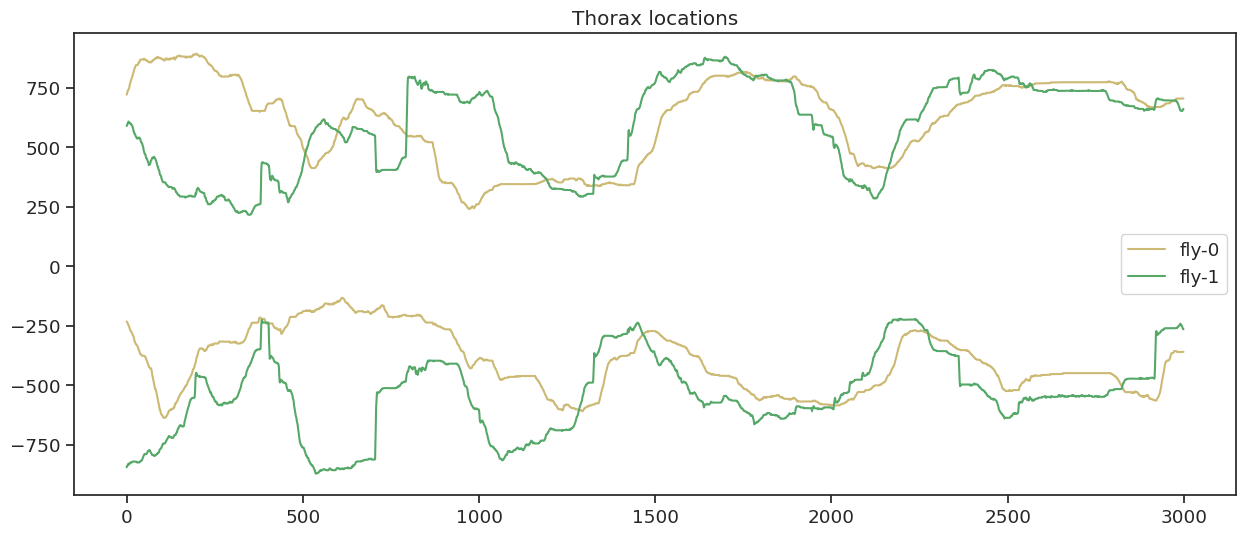

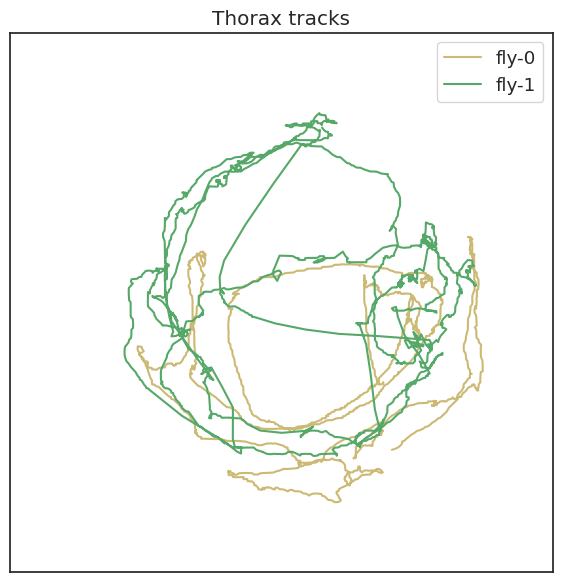

In [8]:
# @title Visualize thorax movement across video
HEAD_INDEX = 0
THORAX_INDEX = 1
ABDO_INDEX = 2

head_loc = locations[:, HEAD_INDEX, :, :]
thorax_loc = locations[:, THORAX_INDEX, :, :]
abdo_loc = locations[:, ABDO_INDEX, :, :]

plt.figure()
plt.plot(thorax_loc[:,0,0], 'y',label='fly-0')
plt.plot(thorax_loc[:,0,1], 'g',label='fly-1')

plt.plot(-1*thorax_loc[:,1,0], 'y')
plt.plot(-1*thorax_loc[:,1,1], 'g')

plt.legend(loc="center right")
plt.title('Thorax locations')


plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0,0],thorax_loc[:,1,0], 'y',label='fly-0')
plt.plot(thorax_loc[:,0,1],thorax_loc[:,1,1], 'g',label='fly-1')
plt.legend()

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Thorax tracks')

## Feature Engineering: Calculating Velocity

Raw coordinates are useful, but derivatives like velocity and acceleration are often more informative for classifying behaviors. Here, we calculate the velocity of each body part using a Savitzky-Golay filter, which smooths the data and computes the derivative in one step.


In [9]:
def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array

    win defines the window to smooth over

    poly defines the order of the polynomial
    to fit with

    """
    node_loc_vel = np.zeros_like(node_loc)

    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)

    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

Text(0.5, 1.0, 'Velocity')

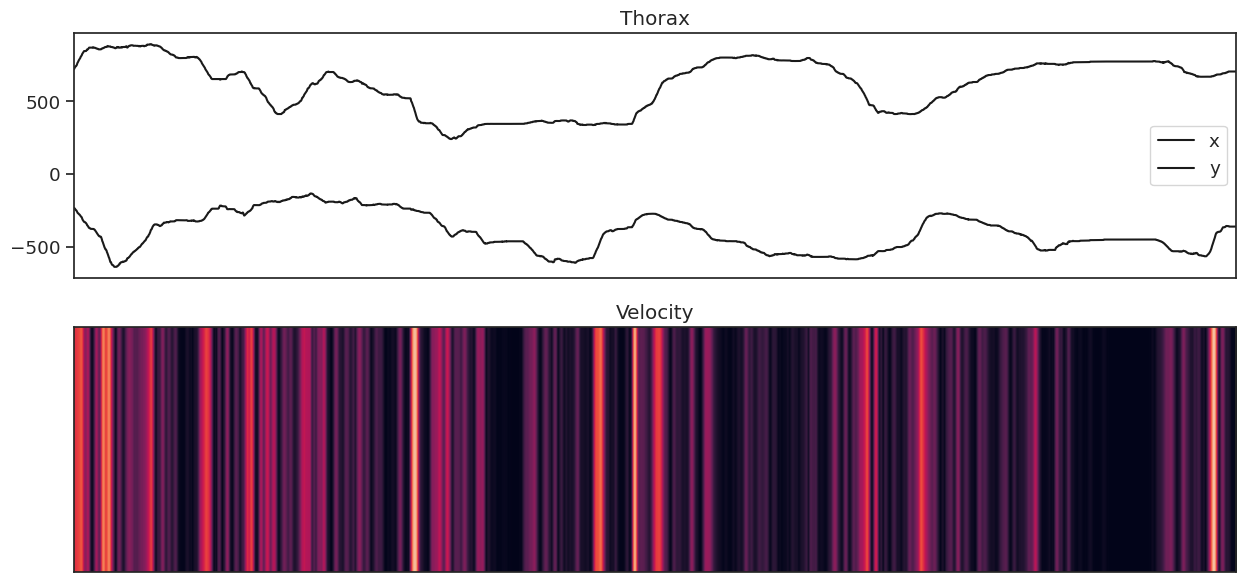

In [10]:
# smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint
thx_vel_fly0 = smooth_diff(thorax_loc[:, :, 0])
thx_vel_fly1 = smooth_diff(thorax_loc[:, :, 1])

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(thx_vel_fly0[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

Text(0.5, 1.0, 'Thorax tracks colored by magnitude of fly speed')

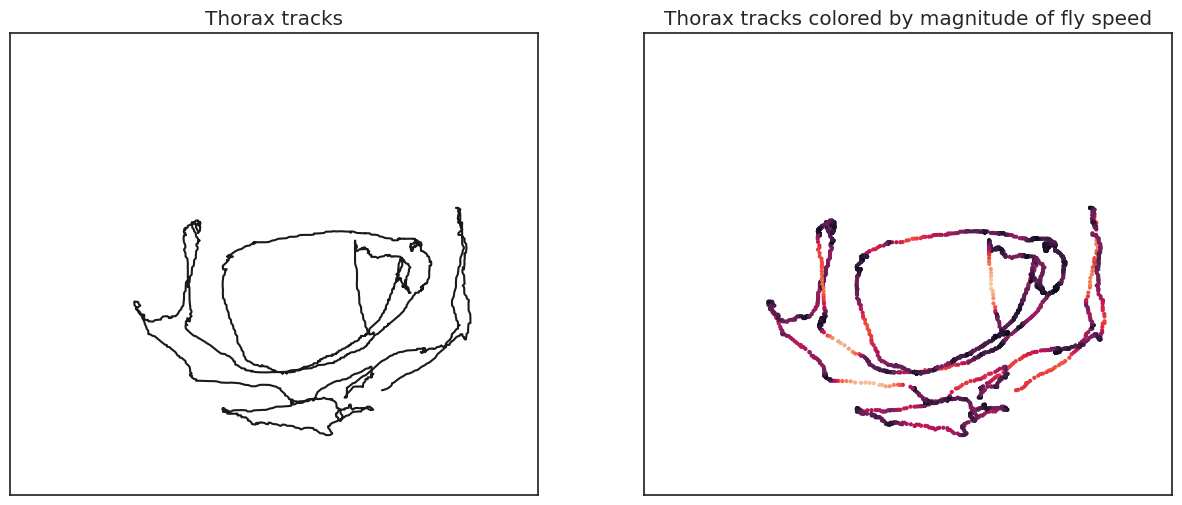

In [11]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_fly0  # use thx_vel_fly1 for other fly
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of fly speed')

In [12]:
def instance_node_velocities(instance_idx):
    fly_node_locations = locations[:, :, :, instance_idx]
    fly_node_velocities = np.zeros((frame_count, node_count))

    for n in range(0, node_count):
        fly_node_velocities[:, n] = smooth_diff(fly_node_locations[:, n, :])

    return fly_node_velocities

In [13]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(node_count), node_names, rotation=20);
    plt.title(f'Fly {instance_idx} node velocities')

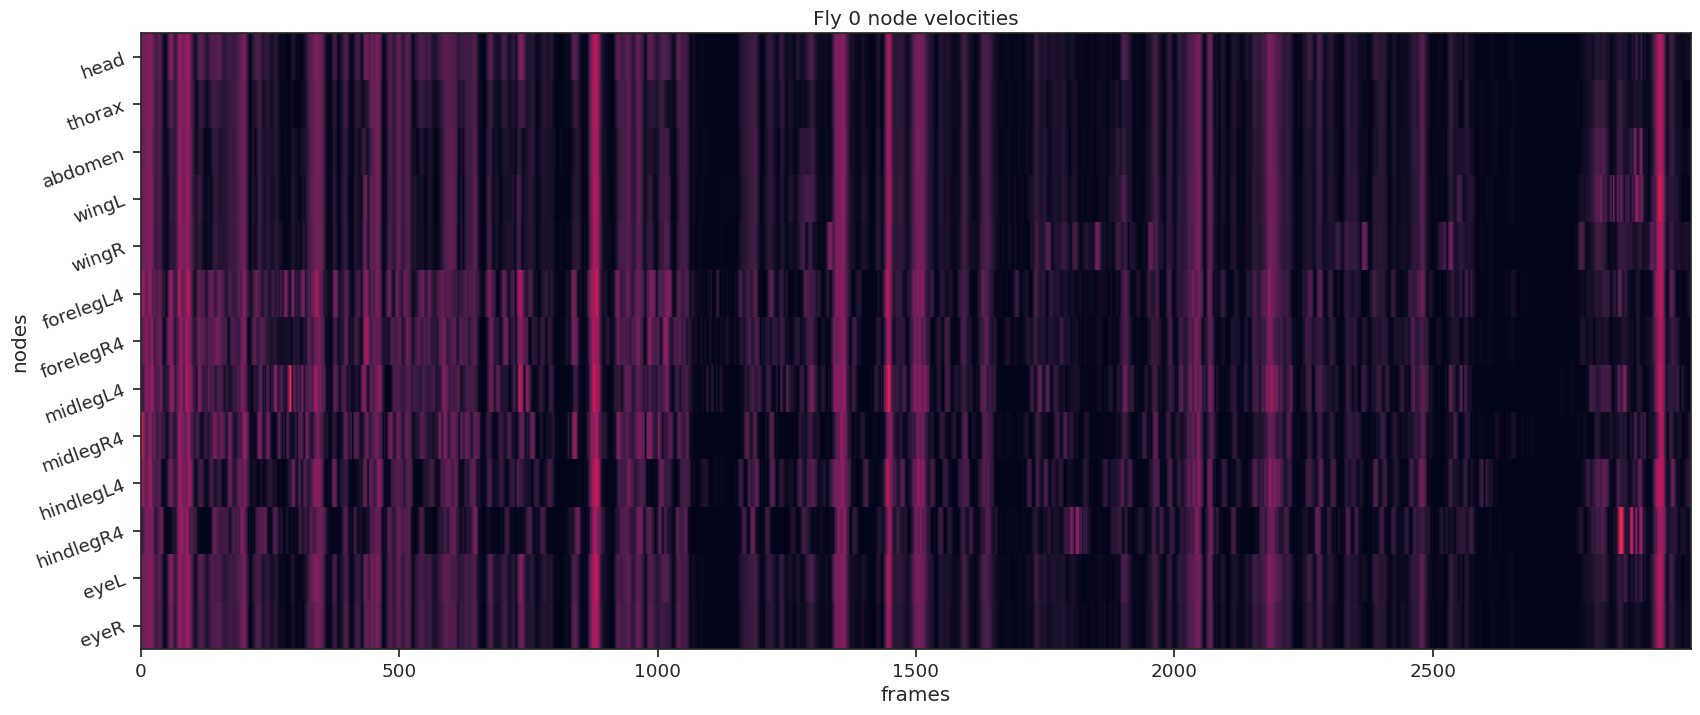

In [14]:
fly_ID = 0
fly_node_velocities0 = instance_node_velocities(fly_ID)
plot_instance_node_velocities(fly_ID, fly_node_velocities0)

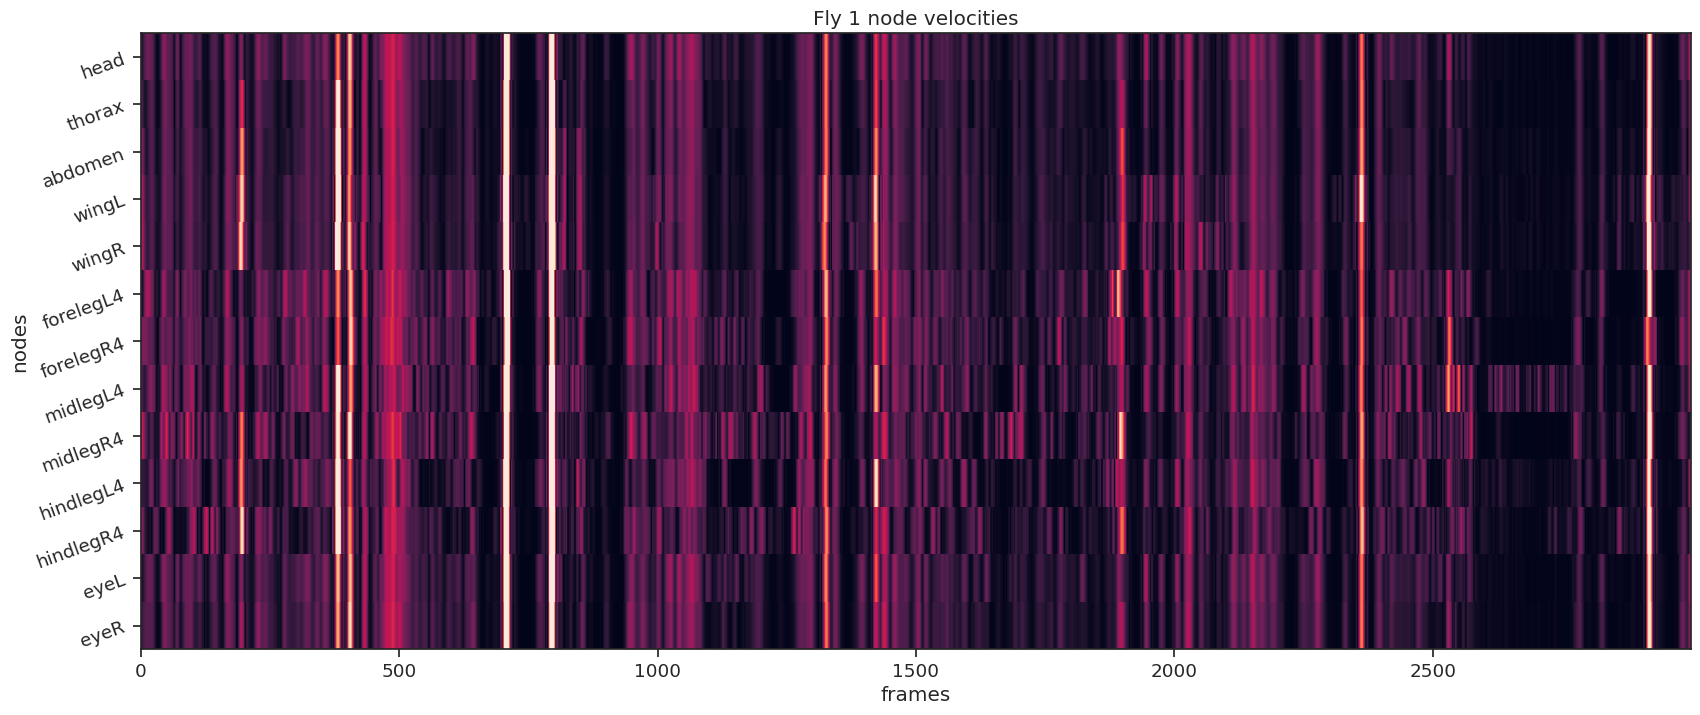

In [15]:
fly_ID = 1
fly_node_velocities1 = instance_node_velocities(fly_ID)
plot_instance_node_velocities(fly_ID, fly_node_velocities1)

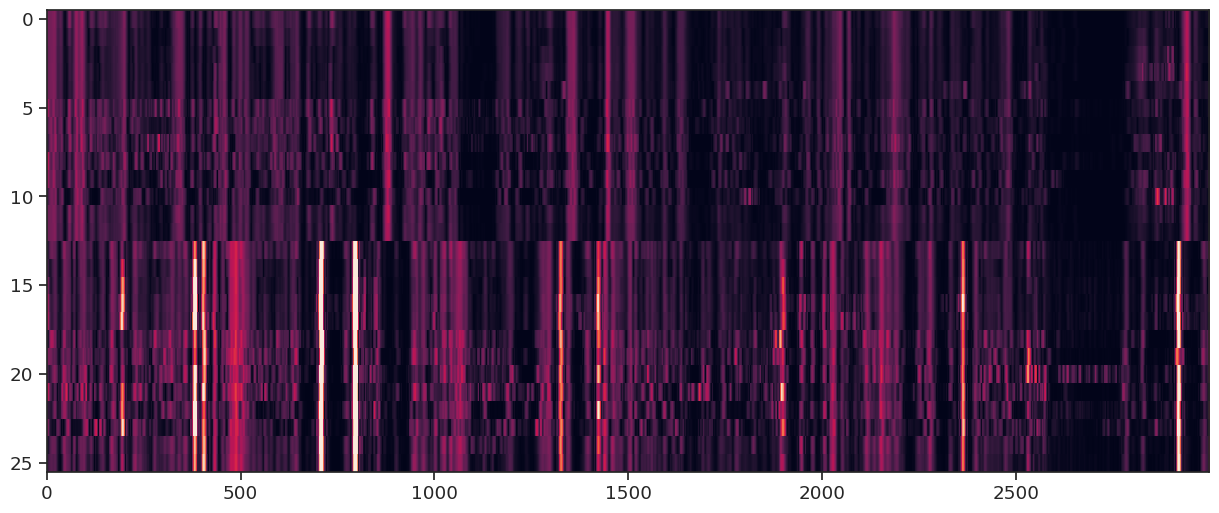

In [16]:
plt.imshow(np.vstack((fly_node_velocities0.T, fly_node_velocities1.T)), aspect='auto', vmin=0, vmax=20, interpolation="nearest")

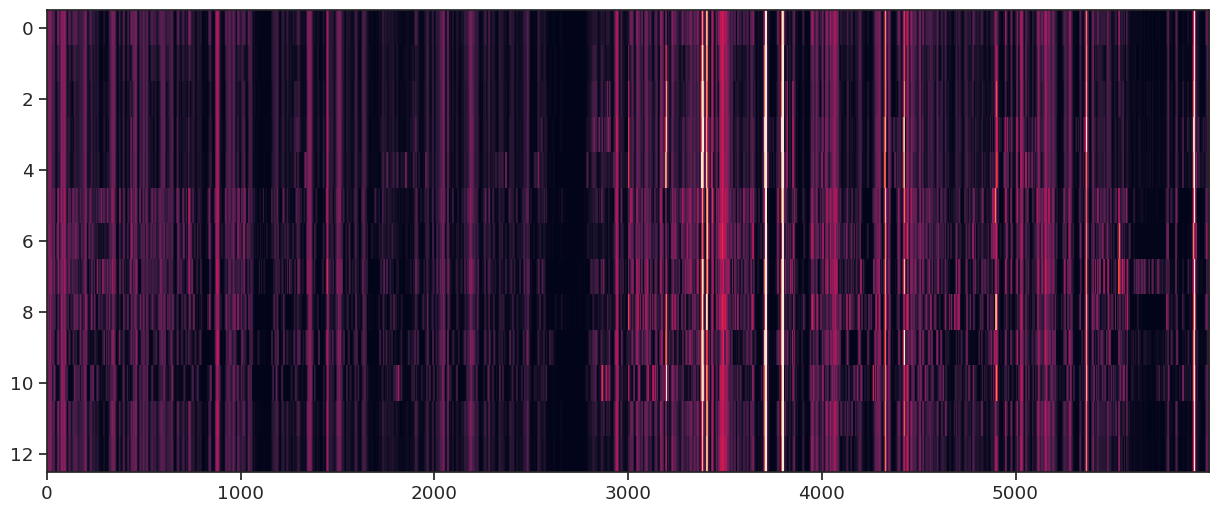

In [17]:
plt.imshow(np.hstack((fly_node_velocities0.T, fly_node_velocities1.T)), aspect='auto', vmin=0, vmax=20, interpolation="nearest")

# Unsupervised Machine Learning for Behavior Discovery

Now we'll use our fly_node_velocities as features to discover behavioral motifs without any pre-existing labels.

In [46]:
fly_node_velocities = np.hstack((fly_node_velocities0.T, fly_node_velocities1.T))

## k-means Clustering

In [47]:
nstates = 10

km = KMeans(n_clusters=nstates)

klabels = km.fit_predict(fly_node_velocities.T)

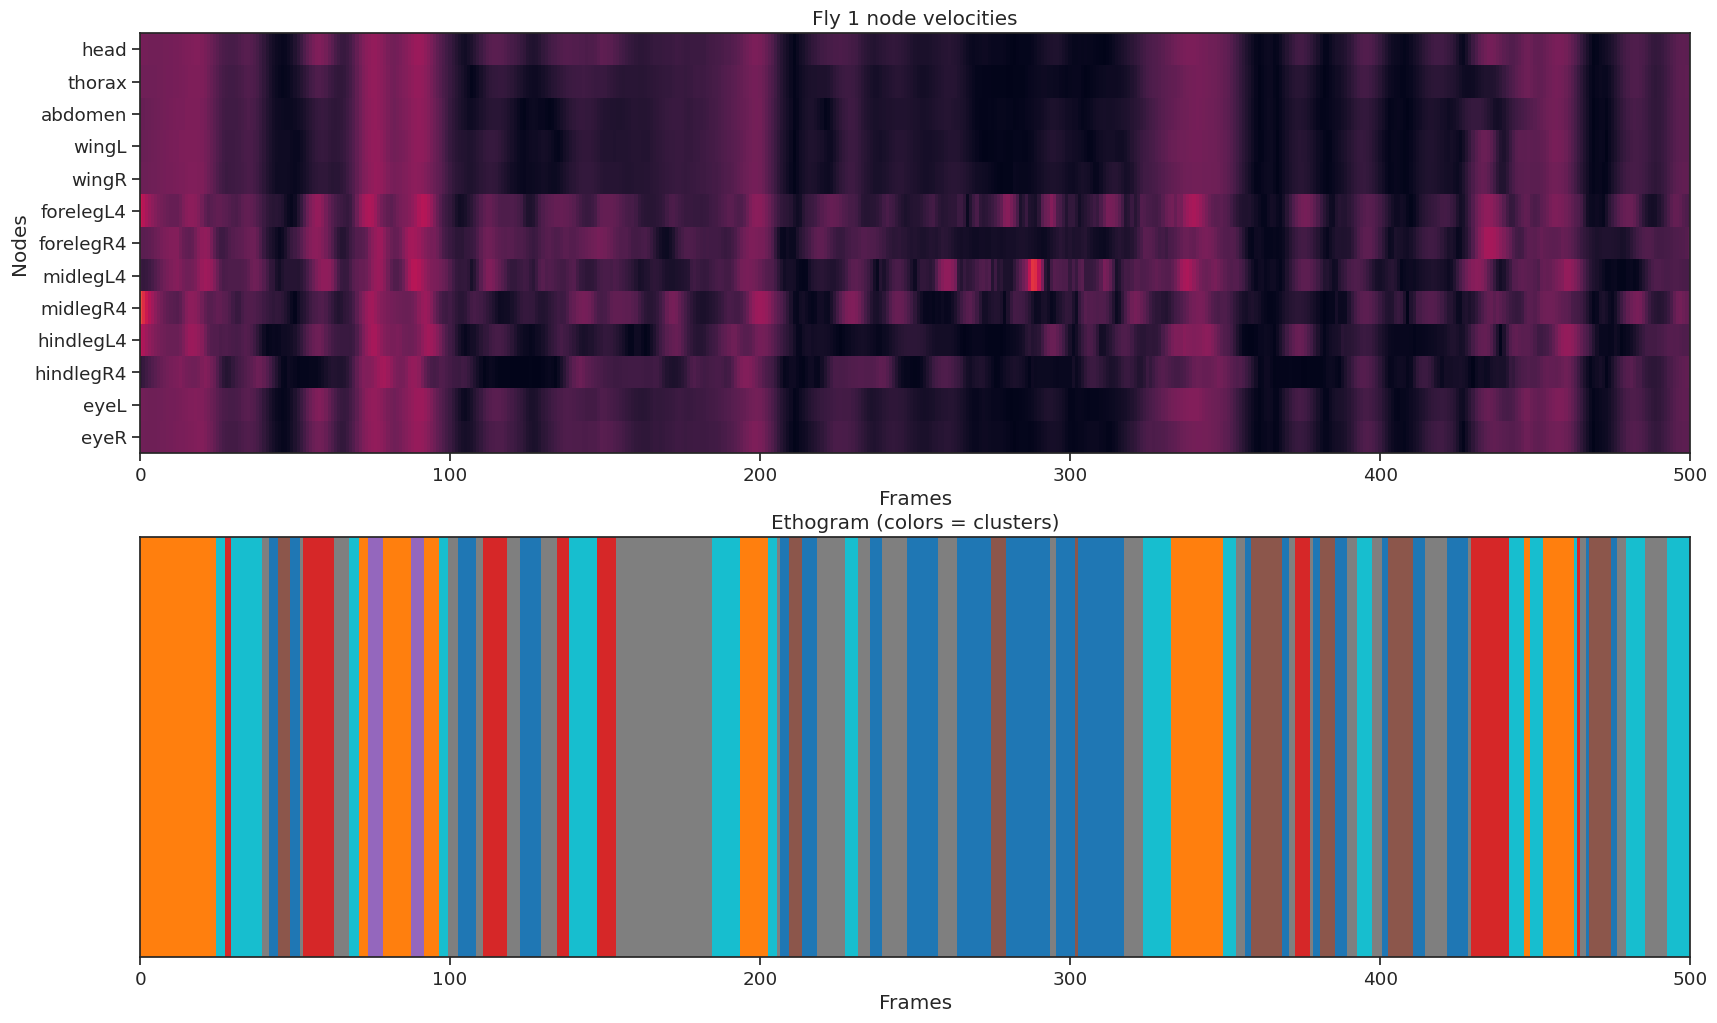

In [48]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(fly_node_velocities, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(node_count))
ax1.set_yticklabels(node_names);
ax1.set_title(f"Fly {fly_ID} node velocities")
ax1.set_xlim(0,500) #frame_count

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(klabels.reshape(1, -1), aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");

## Hierarchical Clustering
Hierarchical clustering builds a tree of nested clusters. It's great for visualizing the relationships between data points at different scales. We'll plot a dendrogram to show these relationships.

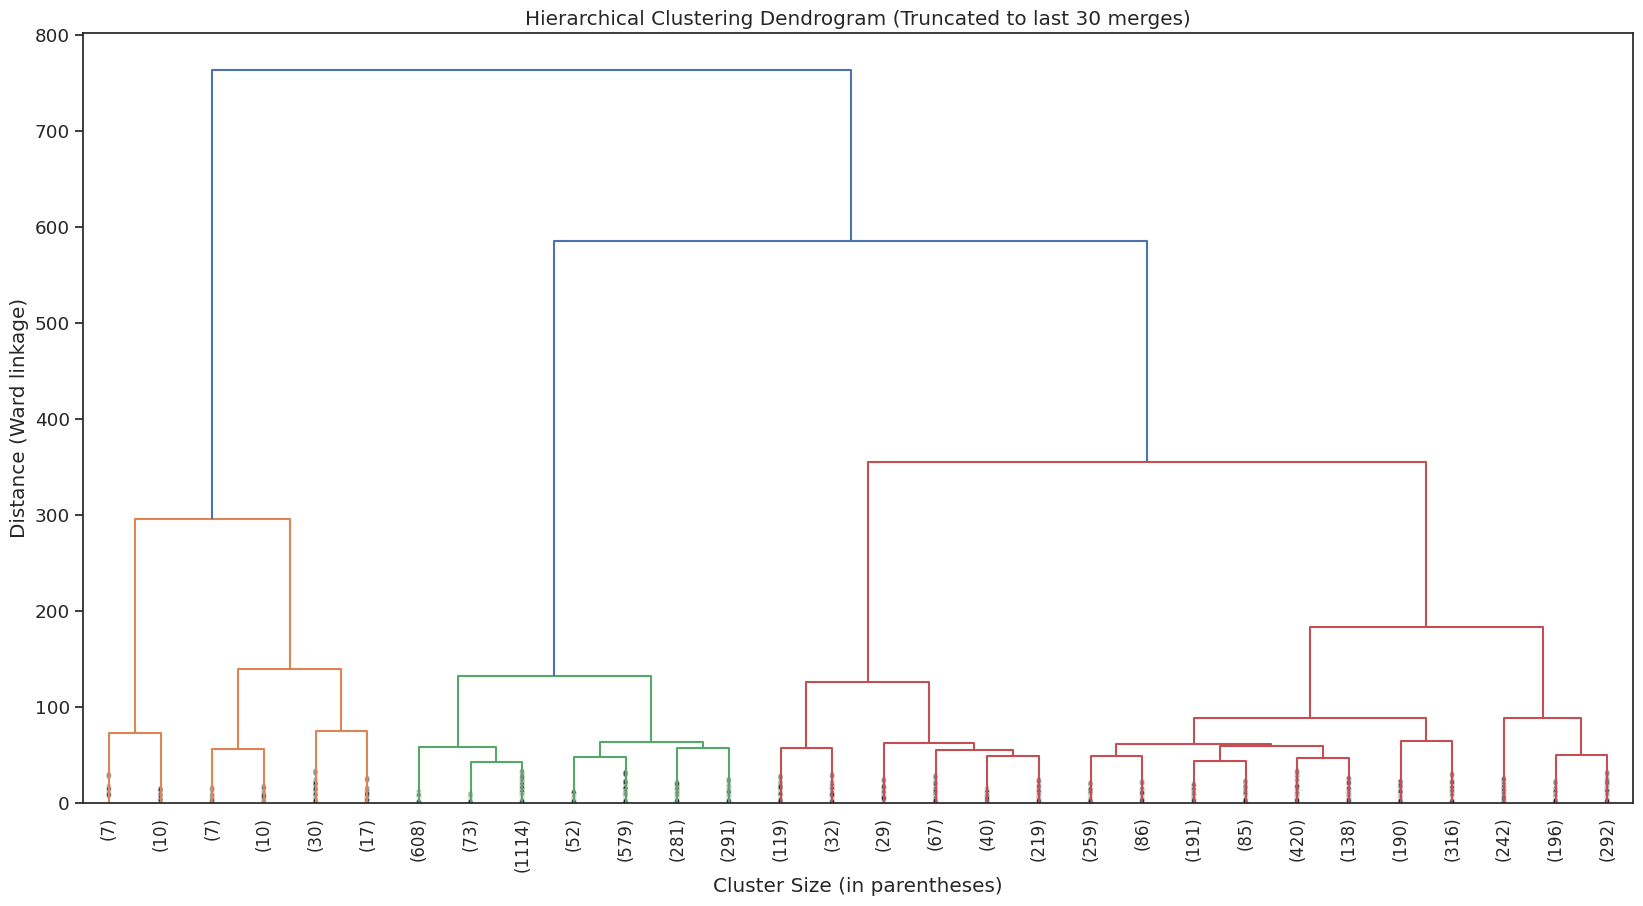

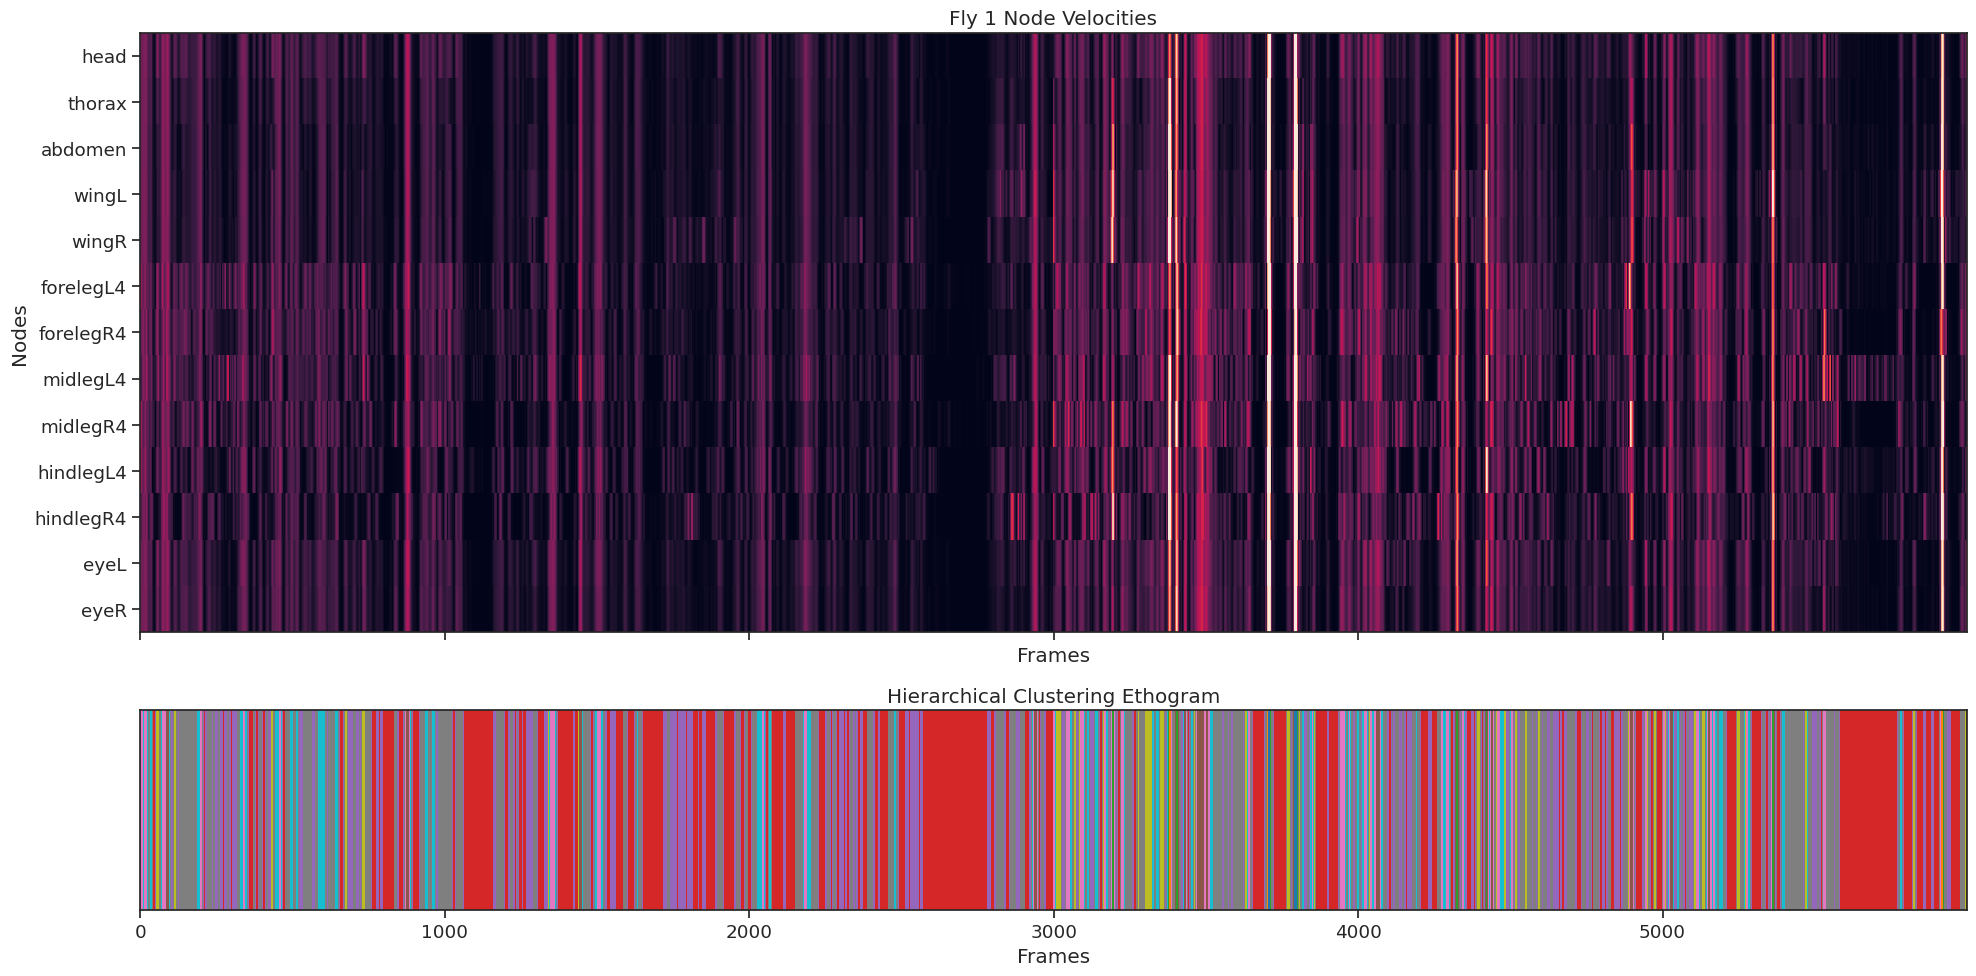

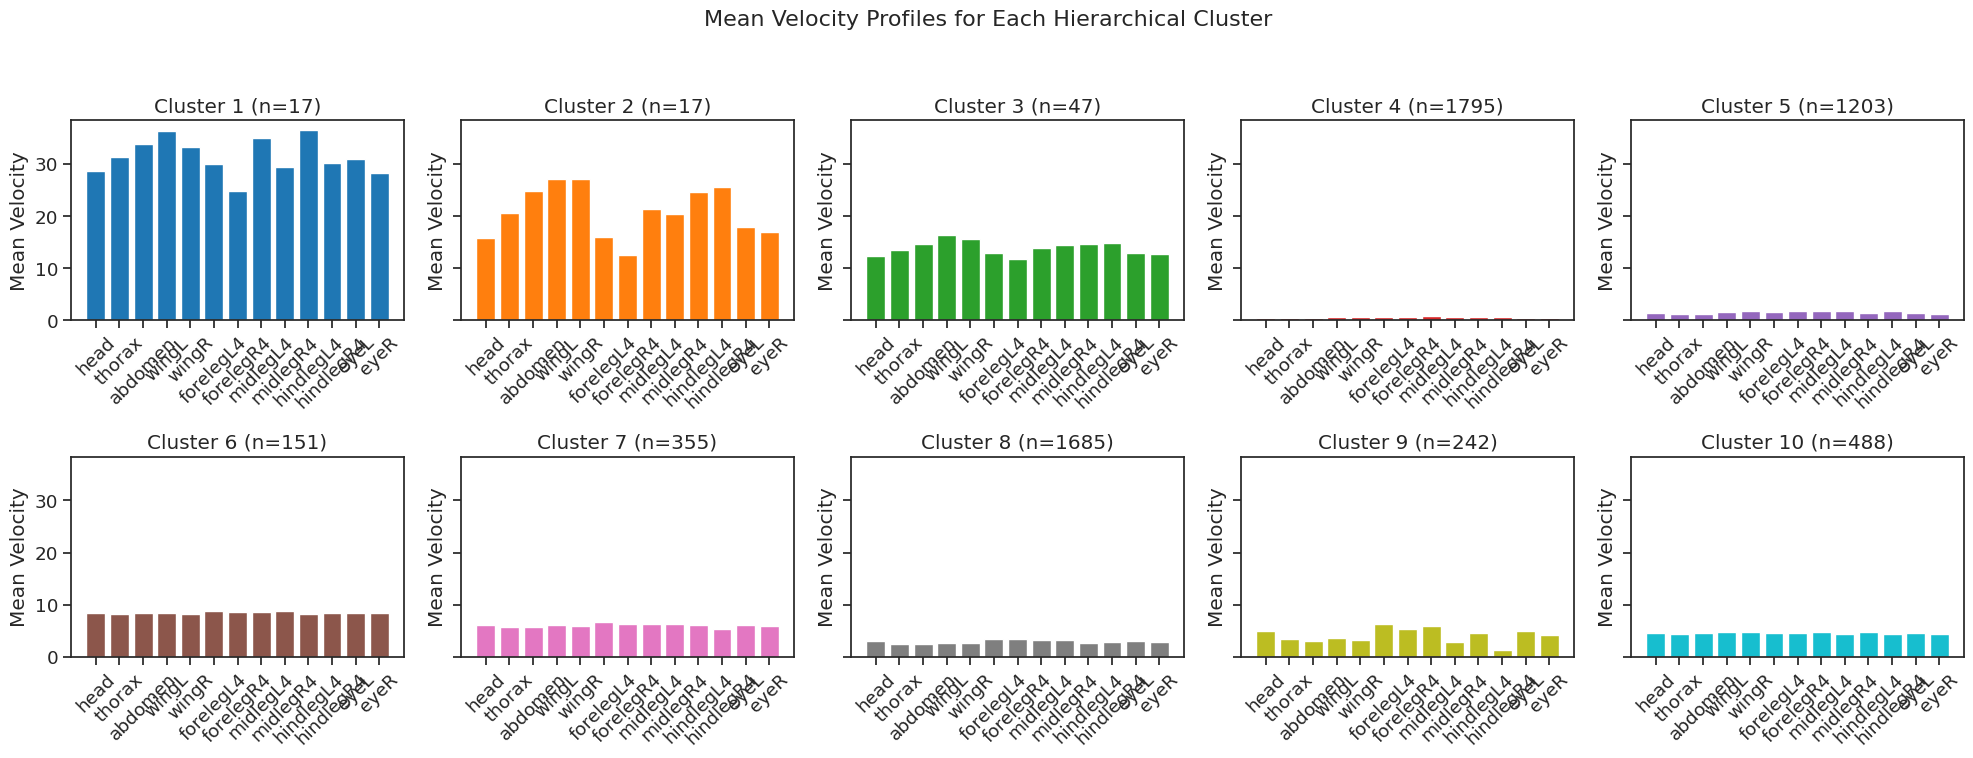

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# --- 1. Randomly Sample Data for Dendrogram Visualization ---
# To avoid a cluttered dendrogram, we'll visualize the structure based on a
# random subset of the data, which is more representative than the first N frames.
n_samples = 500
total_frames = fly_node_velocities.T.shape[0] # Use the correct shape
random_indices = np.random.choice(total_frames, size=n_samples, replace=False) # Add replace=False
subset_data = fly_node_velocities.T[random_indices] # Use the correct data

# --- 2. Perform Hierarchical Clustering and Create an Improved Dendrogram ---
# Perform hierarchical clustering on the full dataset to get the complete structure.
# 'ward' method minimizes the variance of the clusters being merged.
linked = linkage(fly_node_velocities.T, method='ward') # Use the correct data

# Plot a truncated dendrogram for better readability.
# 'truncate_mode='lastp'' shows the last 'p' merged clusters.
# This makes it easy to see the top-level structure without overwhelming detail.
plt.figure(figsize=(20, 10))
dendrogram(
    linked,
    orientation='top',
    truncate_mode='lastp',
    p=30,  # Show only the last 30 merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # To visualize the sizes of truncated branches
)
plt.title('Hierarchical Clustering Dendrogram (Truncated to last 30 merges)')
plt.xlabel('Cluster Size (in parentheses)')
plt.ylabel('Distance (Ward linkage)')
plt.show()


# --- 3. Extract Clusters and Visualize Results ---

# Set the desired number of clusters to extract from the hierarchy.
# We'll choose 10 to match the previous K-Means example for comparison.
n_clusters = 10
hierarchical_labels = fcluster(linked, n_clusters, criterion='maxclust')

# --- Ethogram Visualization ---
# This plot shows the identified behavioral state for each frame over time.
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot the original velocity data
im = axs[0].imshow(fly_node_velocities, aspect="auto", vmin=0, vmax=20, interpolation="nearest") # Use the correct data
axs[0].set_xlabel("Frames")
axs[0].set_ylabel("Nodes")
axs[0].set_yticks(np.arange(node_count))
axs[0].set_yticklabels(node_names)
axs[0].set_title(f"Fly {fly_ID} Node Velocities")
#axs[0].set_xlim(0,500) #frame_count # Remove or adjust xlim based on data

#fig.colorbar(im, ax=axs[0], label="Velocity")

# Plot the ethogram from hierarchical clustering labels
axs[1].imshow(hierarchical_labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest", vmin=1, vmax=n_clusters)
axs[1].set_xlabel("Frames")
axs[1].set_yticks([])
axs[1].set_title("Hierarchical Clustering Ethogram");
plt.tight_layout()
plt.show()

# --- Cluster Inspection: Mean Velocity Profiles ---
# To understand what each cluster represents, we calculate and plot the
# average velocity profile for all frames assigned to that cluster.

# Create subplots for each cluster's profile
fig, axs = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axs = axs.ravel() # Flatten the 2x5 grid into a 1D array for easy iteration

for i in range(n_clusters):
    cluster_id = i + 1  # fcluster labels are 1-based

    # Find all frames belonging to this cluster
    cluster_frames_indices = np.where(hierarchical_labels == cluster_id)[0]

    if len(cluster_frames_indices) > 0:
        # Calculate the mean velocity profile for the cluster
        mean_profile = fly_node_velocities.T[cluster_frames_indices].mean(axis=0) # Calculate mean profile correctly

        # Plot the mean profile as a bar chart
        axs[i].bar(node_names, mean_profile, color=plt.cm.tab10(i / n_clusters))
        axs[i].set_title(f"Cluster {cluster_id} (n={len(cluster_frames_indices)})")
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].set_ylabel("Mean Velocity")
    else:
        axs[i].set_title(f"Cluster {cluster_id} (n=0)")
        axs[i].text(0.5, 0.5, 'No frames', ha='center', va='center')

fig.suptitle("Mean Velocity Profiles for Each Hierarchical Cluster", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

## Auto-regressive Hidden Markov Model (AR-HMM)

AR-HMMs are powerful for time-series data because they model both the distinct behavioral "states" (like K-Means) and the probabilities of transitioning between them. Each state is defined by an auto-regressive model, capturing the dynamics of the behavior.

In [22]:
!git clone https://github.com/mginesi/nl_arhmm.git

Cloning into 'nl_arhmm'...
remote: Enumerating objects: 748, done.
remote: Counting objects: 100% (748/748), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 748 (delta 489), reused 744 (delta 485), pack-reused 0 (from 0)
Receiving objects: 100% (748/748), 219.27 KiB | 2.92 MiB/s, done.
Resolving deltas: 100% (489/489), done.


In [25]:
%cd ..
!pip install .

/content/nl_arhmm
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nl_arhmm-0.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Processing /content/nl_arhmm
  Preparing metadata (setup.py) ... done
  Created wheel for nl_arhmm: filename=nl_arhmm-0.1-py3-none-any.whl size=16142 sha256=f9a721d07362081bbd2fa77fe01898a22a23d1fe1e73aee2b4ecdcd05a0b9c15
  Stored in directory: /tmp/pip-ephem-wheel-cache-sk9t5ben/wheels/74/39/fc/7ada9bec44e329fd100debdb02dac7a6bf77a4da5288bca2b5
Successfully built nl_arhmm
  Attempting uninstall: nl_arhmm
    Found existing installation: nl_arhmm 0.1
    Uninstalling nl_arhmm-0.1:
      Successfully uninstalled nl_arhmm-0.1


Shape of velocity data (features, frames): (13, 6000)

Initializing AR-HMM...
Training AR-HMM with EM algorithm...
Step 0: LH = -108740.72734509897
Step 1: LH = -28111.868341911868
Step 2: LH = 1962.2586919898658
Step 3: LH = 5717.3070024651715
Step 4: LH = 6992.847448657002
Step 5: LH = 7527.883794443429
Step 6: LH = 7772.526843237325
Training complete.

 -- Inferred Model --
Initial density:
[9.9999996e-01 9.9999995e-09 9.9999995e-09 9.9999995e-09 1.0000126e-08]

Transition matrix:
[[9.67226504e-01 9.99999950e-09 2.12154911e-04 9.99999950e-09
  3.25613213e-02]
 [2.00000000e-01 2.00000000e-01 2.00000000e-01 2.00000000e-01
  2.00000000e-01]
 [9.99999960e-01 9.99999960e-09 9.99999960e-09 9.99999960e-09
  1.00000003e-08]
 [2.00000000e-01 2.00000000e-01 2.00000000e-01 2.00000000e-01
  2.00000000e-01]
 [1.18828935e-01 9.99999950e-09 1.00000006e-08 9.99999950e-09
  8.81171035e-01]]

--- State 0 Dynamics ---
Weights (A matrix and b vector):
Covariance (noise):

--- State 1 Dynamics ---
Weigh

/tmp/ipython-input-2566919100.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_states = plt.cm.get_cmap('tab10', n_states)


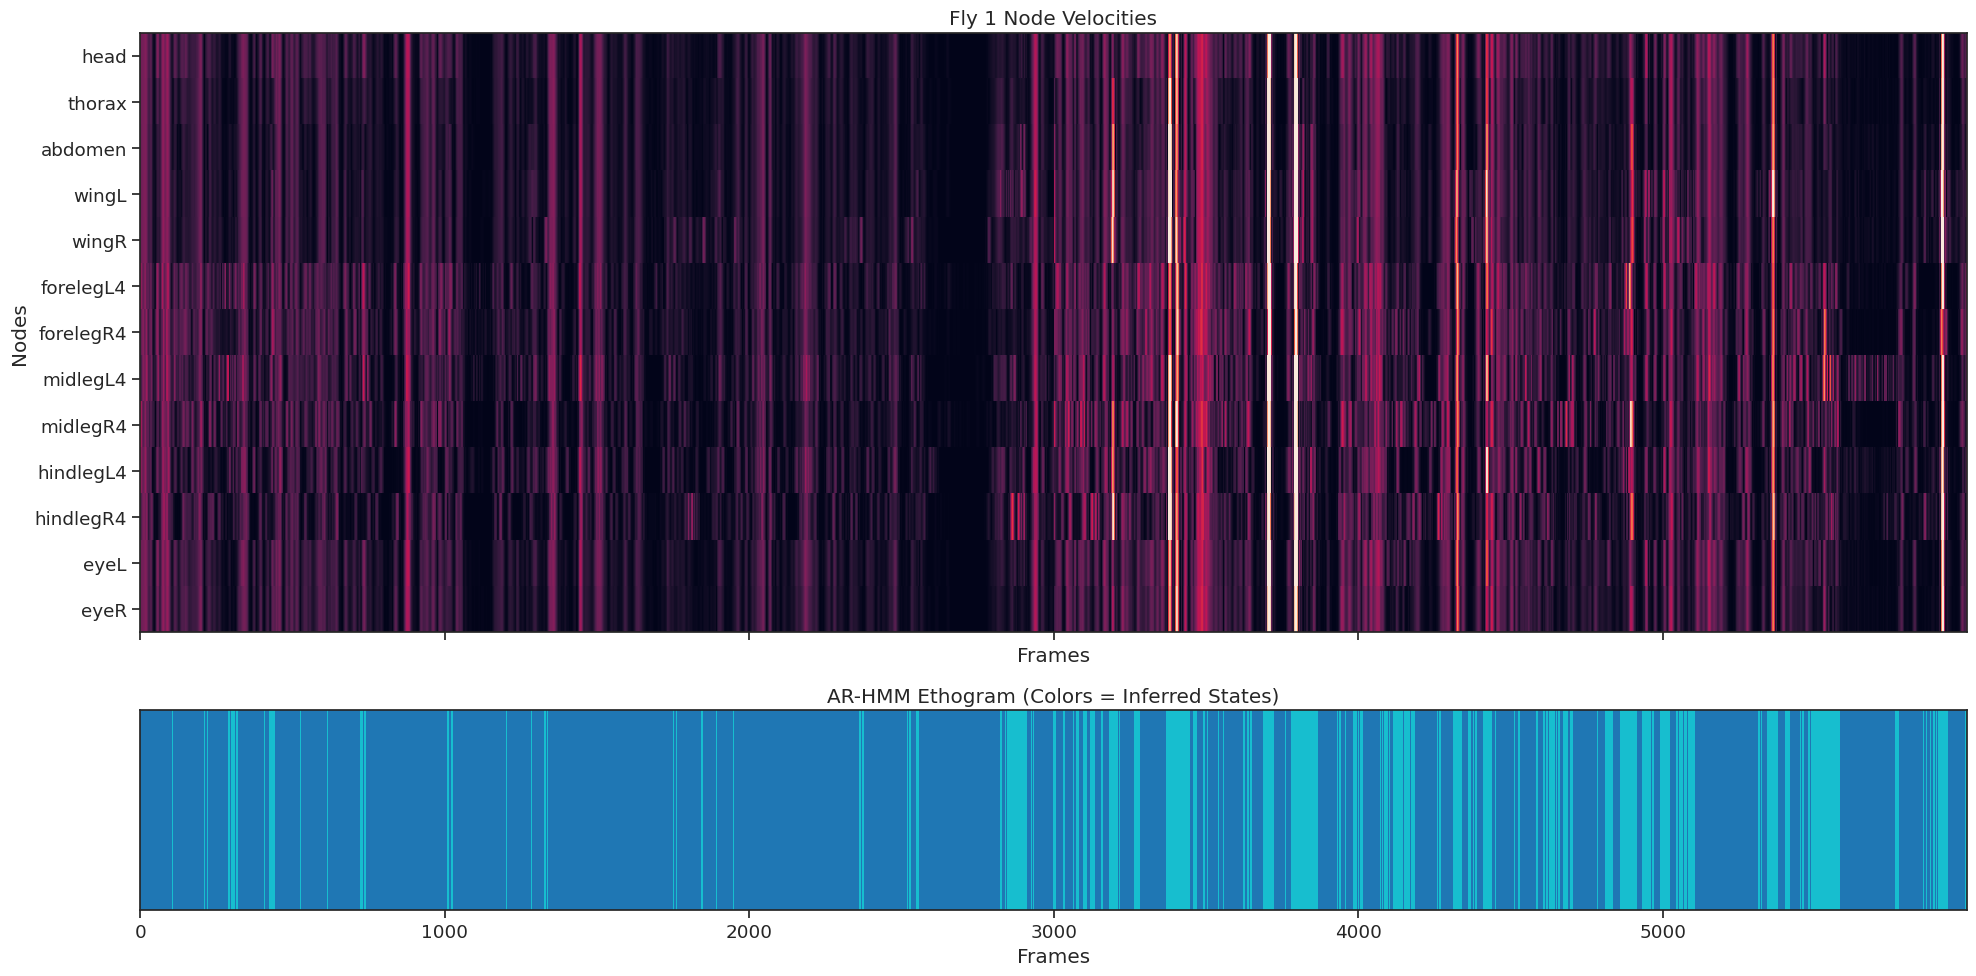

In [67]:
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from nl_arhmm.arhmm import Linear_ARHMM
import subprocess


# Fill missing values and calculate velocities
locations = fill_missing(locations)
fly_node_velocities0 = instance_node_velocities(0)
fly_node_velocities1 = instance_node_velocities(1)

# Combine flies into a single long timeseries of shape (features, frames)
fly_node_velocities = np.hstack((fly_node_velocities0.T, fly_node_velocities1.T))
print(f"Shape of velocity data (features, frames): {fly_node_velocities.shape}")

# Prepare data for the ARHMM library: a list of [(frames, features)]
emissions_data = [fly_node_velocities.T]

# --- 2. AR-HMM IMPLEMENTATION (adapted from demo) ---

# Model parameters
n_states = 5  # Number of behavioral states to discover
n_dims = fly_node_velocities.shape[0]  # Number of features (nodes)

# Instantiate a new model
model = Linear_ARHMM(n_states, n_dims)

# Initialize and train the model on the fly data
print("\nInitializing AR-HMM...")
model.initialize(emissions_data)
print("Training AR-HMM with EM algorithm...")
model.em_algorithm(emissions_data)
print("Training complete.")

# Predict the most likely sequence of states (Viterbi algorithm)
predicted_states = model.viterbi(emissions_data[0])

# --- 3. PRINTING INFERRED PARAMETERS ---
print("\n -- Inferred Model --")
print("Initial density:")
print(model.initial.density)
print("\nTransition matrix:")
print(model.transition.trans_mtrx)

for i in range(n_states):
    print(f"\n--- State {i} Dynamics ---")
    print("Weights (A matrix and b vector):")
    #print(model.dynamics[i].weights)
    print("Covariance (noise):")
    #print(model.dynamics[i].covariance)


# --- 4. PLOTTING ---
print("\nGenerating ethogram...")
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot the original velocity data
im = axs[0].imshow(fly_node_velocities, aspect="auto", vmin=0, vmax=20, interpolation="nearest") # Use the correct data
axs[0].set_xlabel("Frames")
axs[0].set_ylabel("Nodes")
axs[0].set_yticks(np.arange(node_count))
axs[0].set_yticklabels(node_names)
axs[0].set_title(f"Fly {fly_ID} Node Velocities")

# Plot the ethogram from AR-HMM labels
cmap_states = plt.cm.get_cmap('tab10', n_states)
axs[1].imshow(predicted_states[None, :], aspect="auto", cmap=cmap_states, interpolation="nearest")
axs[1].set_xlabel("Frames")
axs[1].set_yticks([])
axs[1].set_title("AR-HMM Ethogram (Colors = Inferred States)")

plt.tight_layout()
plt.show()

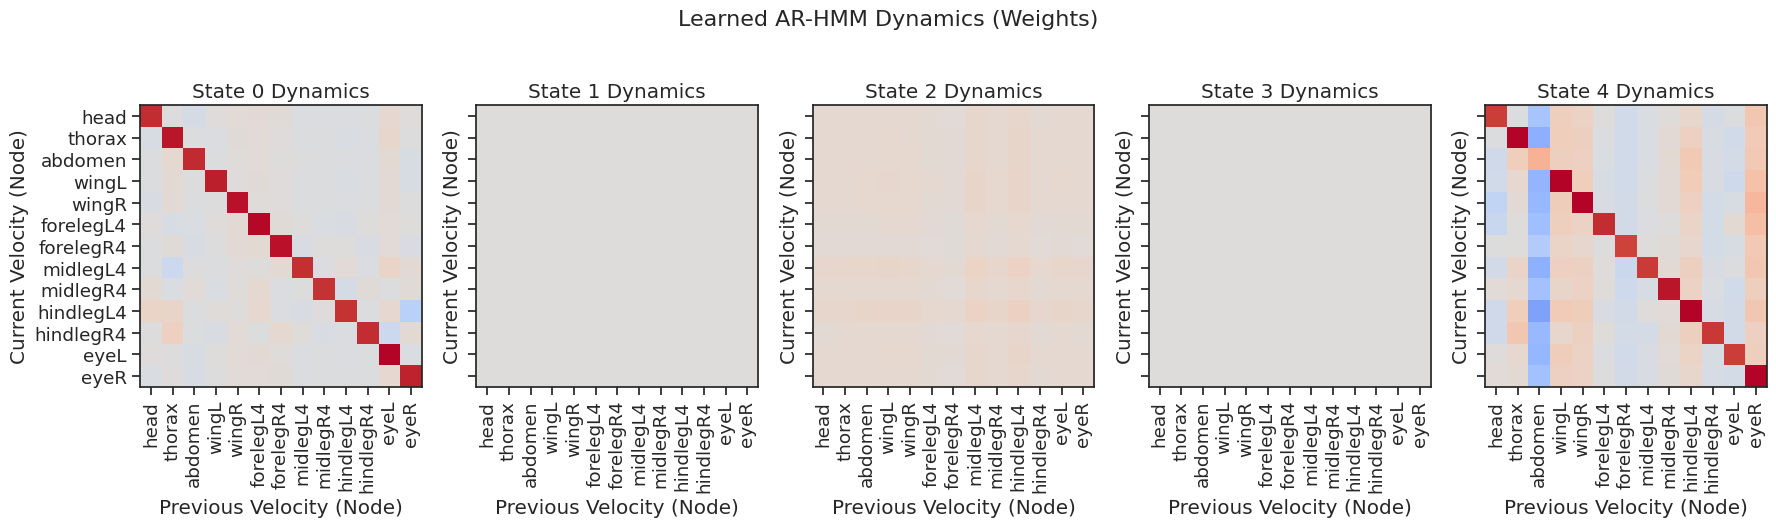

In [68]:
# Assuming 'model' and 'n_states' are available
fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharex=True, sharey=True)
fig.suptitle('Learned AR-HMM Dynamics (Weights)', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i < 5: # Only 3 states were found
        # Weights are (features, 1 + features). We skip the first column (bias).
        weights = model.dynamics[i].weights[:, 1:]
        im = ax.imshow(weights, cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_title(f'State {i} Dynamics')
        ax.set_ylabel('Current Velocity (Node)')
        ax.set_xlabel('Previous Velocity (Node)')
        ax.set_xticks(np.arange(len(node_names)))
        ax.set_xticklabels(node_names, rotation=90)
        ax.set_yticks(np.arange(len(node_names)))
        ax.set_yticklabels(node_names)

#fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

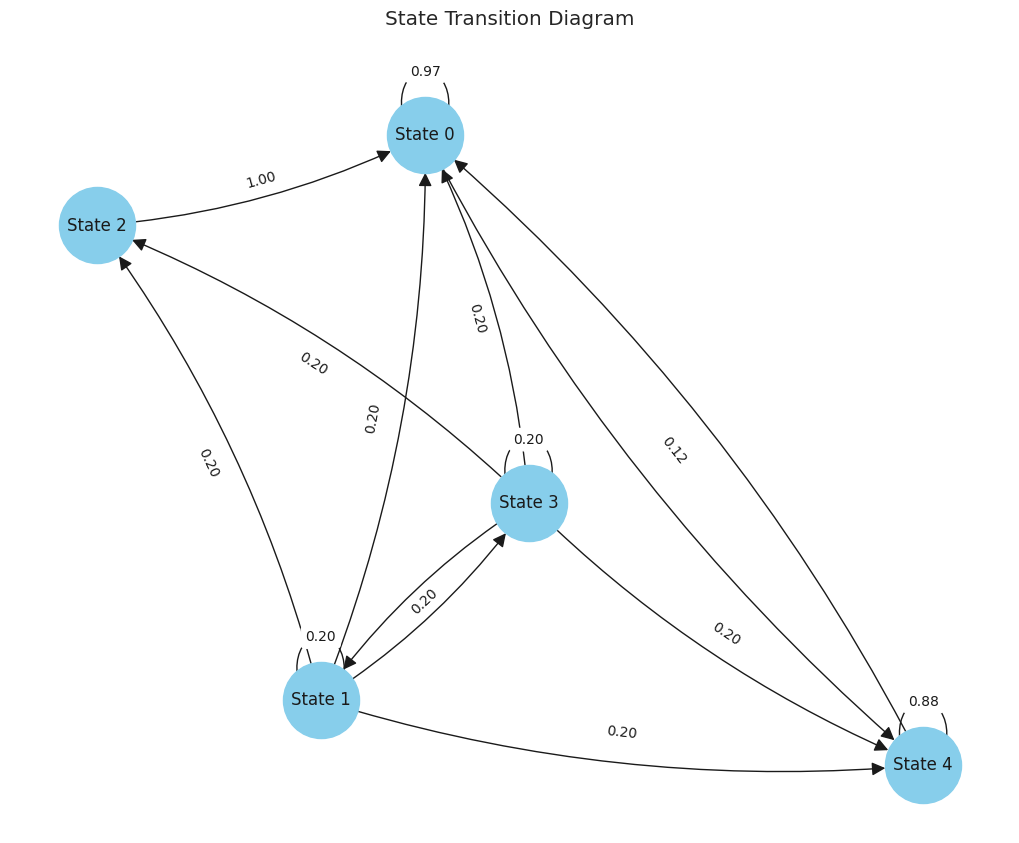

In [69]:
import networkx as nx

# Create a directed graph
G = nx.MultiDiGraph()
labels = {}
for i, row in enumerate(model.transition.trans_mtrx):
    for j, prob in enumerate(row):
        if prob > 0.01:  # Only draw significant transitions
            G.add_edge(f"State {i}", f"State {j}", weight=prob, label=f"{prob:.2f}")

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000,
        connectionstyle='arc3,rad=0.1', arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("State Transition Diagram")
plt.show()

## Wavelet Transform and t-SNE (MotionMapper approach)
This technique uses a continuous wavelet transform (CWT) to create a spectrogram for each velocity timeseries, capturing frequency information. These spectrograms are then embedded into a 2D space using t-SNE for visualization and clustering.

Shape of pairwise distance feature matrix: (6000, 78)


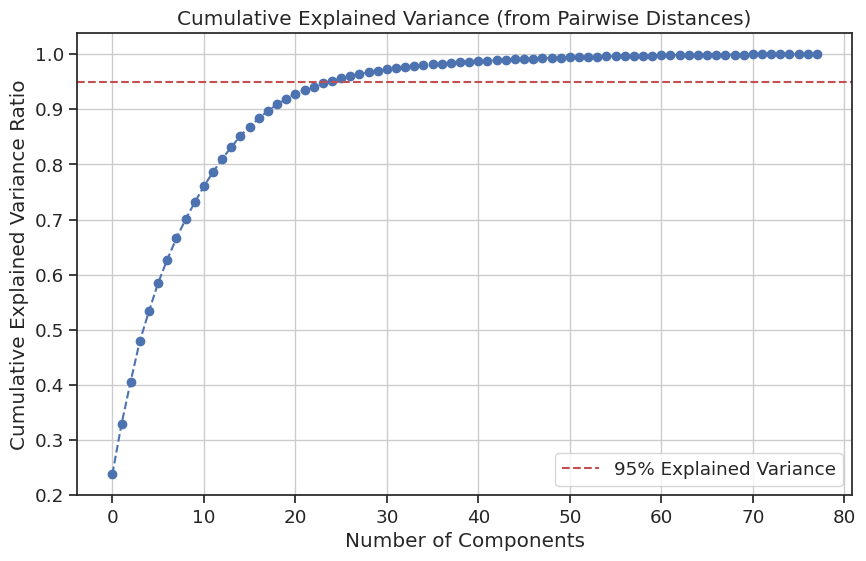

Shape of PCA features for next step: (6000, 20)
Shape of CWT features for UMAP: (6000, 600)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN found 1 distinct clusters.


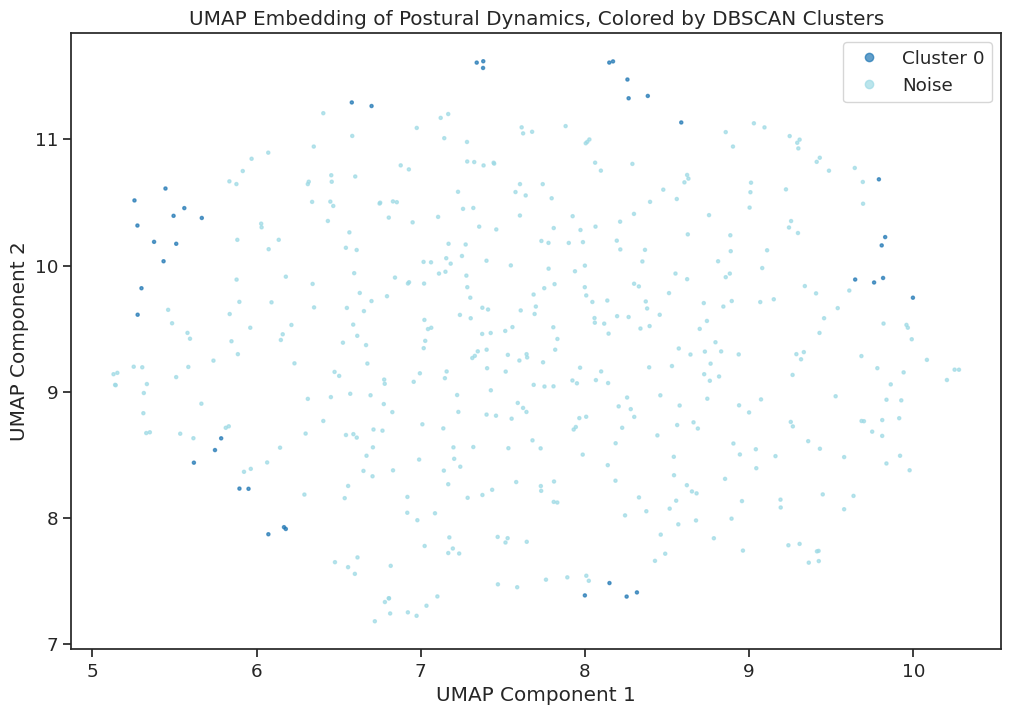

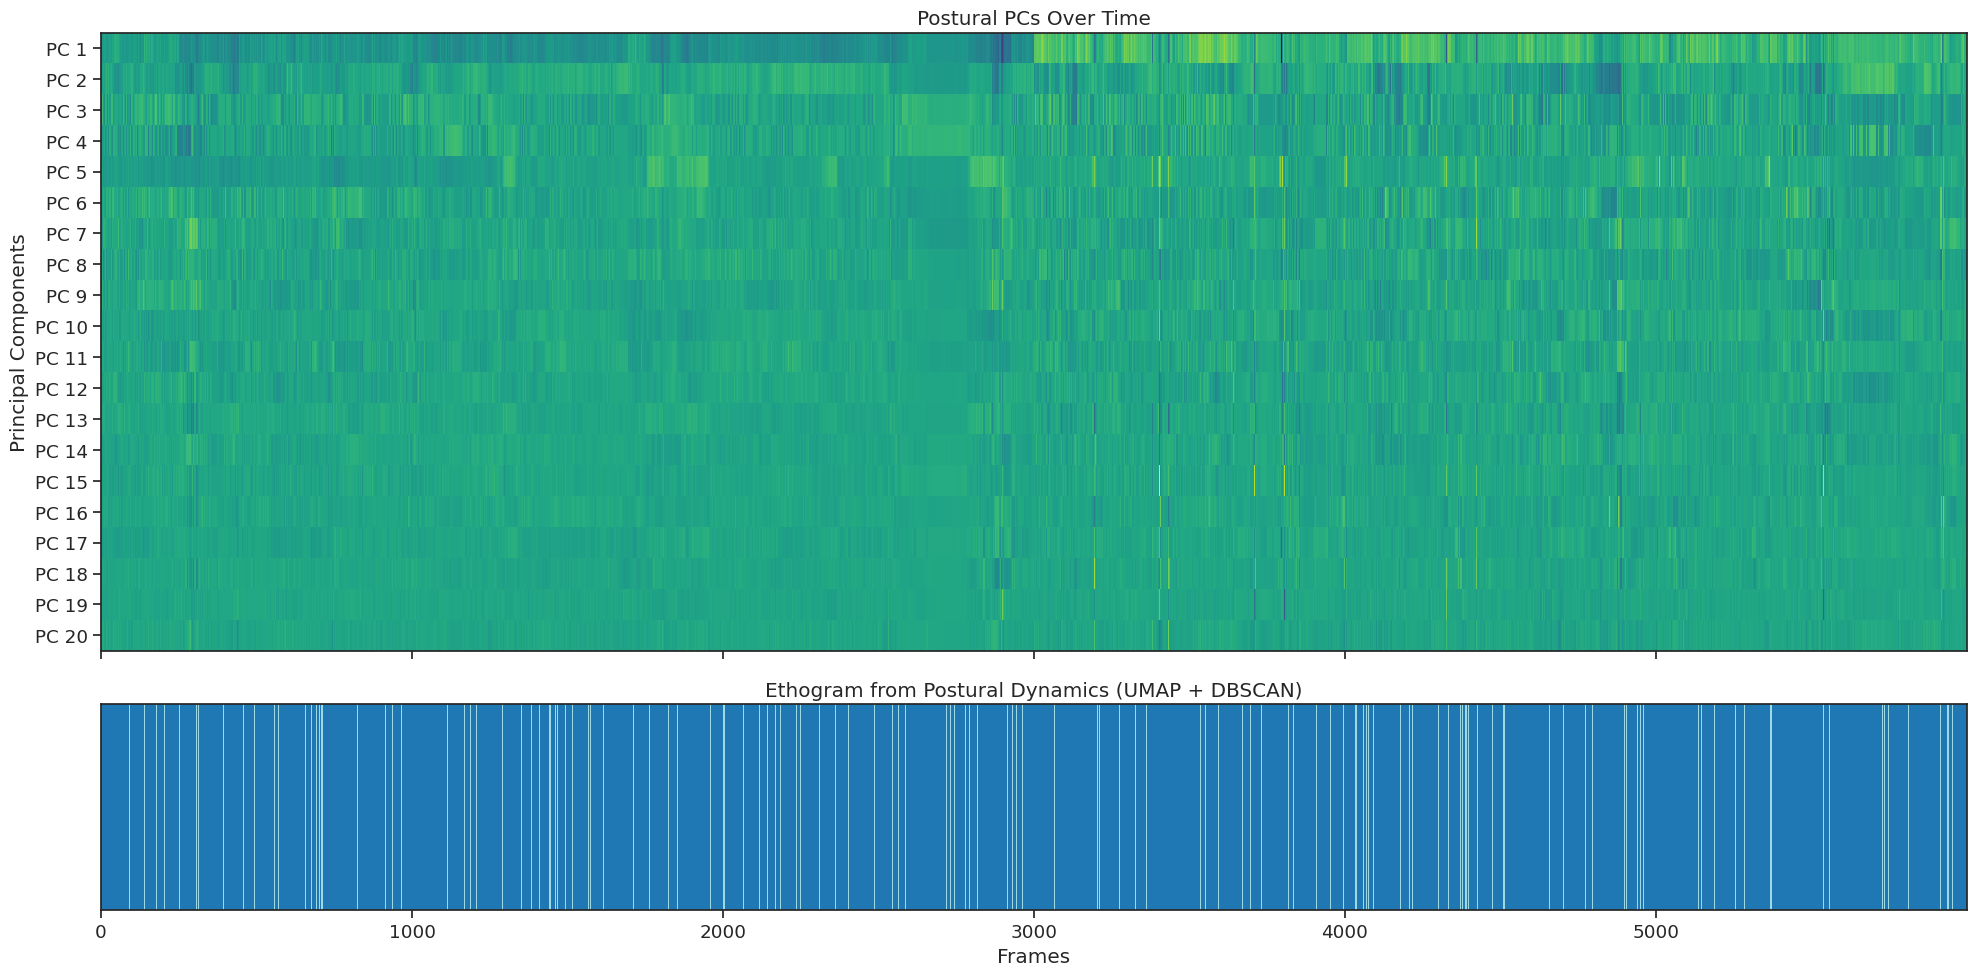

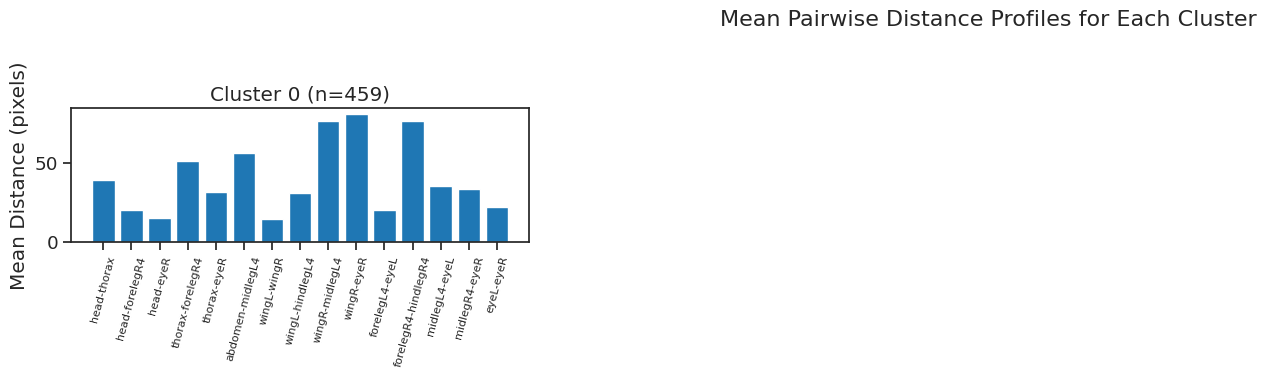

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pywt
import umap.umap_ as umap  # Import UMAP
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import itertools

# --- 1. Feature Generation: Pairwise Body Part Distances for Both Flies ---
# We stack the data from fly 0 and fly 1 into a single long timeseries.
# This allows the model to find common postural states across both animals.
fly_locations_0 = locations[:, :, :, 0]
fly_locations_1 = locations[:, :, :, 1]
combined_fly_locations = np.vstack((fly_locations_0, fly_locations_1))

n_frames, n_nodes, _ = combined_fly_locations.shape

# Generate all unique pairs of node indices (for intra-fly distances)
node_pairs = list(itertools.combinations(range(n_nodes), 2))
n_features = len(node_pairs)

# Create feature matrix to store pairwise distances
pairwise_distances = np.zeros((n_frames, n_features))

# Create labels for each feature using the original node_names
feature_labels = [f"{node_names[n1]}-{node_names[n2]}" for n1, n2 in node_pairs]

# Calculate distances for each frame
for i, (node1_idx, node2_idx) in enumerate(node_pairs):
    pairwise_distances[:, i] = np.linalg.norm(combined_fly_locations[:, node1_idx, :] - combined_fly_locations[:, node2_idx, :], axis=1)

print(f"Shape of pairwise distance feature matrix: {pairwise_distances.shape}")


# --- 2. Run PCA on Pairwise Distance Features ---
scaler = StandardScaler()
scaled_distances = scaler.fit_transform(pairwise_distances)

pca = PCA()
principal_components = pca.fit_transform(scaled_distances)

# Analyze explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance (from Pairwise Distances)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

# Select the top N components
num_pcs_to_use = 20
pca_features = principal_components[:, :num_pcs_to_use]
print(f"Shape of PCA features for next step: {pca_features.shape}")


# --- 3. Wavelet Transform on Principal Components ---
scales = np.geomspace(0.25, 30, num=30)
cwt_coeffs, freqs = pywt.cwt(pca_features, scales, 'morl', axis=0)

num_scales, num_frames, num_pcs = cwt_coeffs.shape
cwt_transposed = cwt_coeffs.transpose(1, 0, 2)
cwt_reshaped = cwt_transposed.reshape(num_frames, num_scales * num_pcs)
print(f"Shape of CWT features for UMAP: {cwt_reshaped.shape}")


# --- 4. UMAP Embedding, Clustering, and Visualization ---
# Run UMAP on a random subset for efficiency
subset_size = 500
total_frames = pca_features.shape[0]

if total_frames > subset_size:
    umap_indices = np.random.choice(total_frames, size=subset_size, replace=False)
    umap_data = cwt_reshaped[umap_indices]
else:
    umap_indices = np.arange(total_frames)
    umap_data = cwt_reshaped

# Instantiate and fit UMAP
# n_neighbors: Controls local vs. global structure balance (like perplexity).
# min_dist: Controls how tightly packed points are in the embedding.
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=123)
embedding = reducer.fit_transform(umap_data)

# Cluster the embedding with DBSCAN
# Note: The optimal `eps` for DBSCAN may need tuning based on the embedding's density.
dbscan = DBSCAN(eps=0.5, min_samples=20)
umap_labels = dbscan.fit_predict(embedding)
n_clusters_found = len(set(umap_labels)) - (1 if -1 in umap_labels else 0)
print(f"DBSCAN found {n_clusters_found} distinct clusters.")

# Create the full label array
postural_labels = np.full(total_frames, -1, dtype=int)
postural_labels[umap_indices] = umap_labels

# Visualize the clustered behavioral space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=umap_labels, cmap='tab20', s=5, alpha=0.7)
plt.title("UMAP Embedding of Postural Dynamics, Colored by DBSCAN Clusters")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
handles, _ = scatter.legend_elements()
legend_labels = [f'Cluster {i}' for i in np.unique(umap_labels) if i != -1]
if -1 in np.unique(umap_labels): legend_labels.append('Noise')
plt.legend(handles, legend_labels)
plt.show()


# --- 5. Ethogram and Cluster Interpretation ---
# Ethogram showing PC dynamics and resulting clusters
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
axs[0].imshow(pca_features.T, aspect="auto", cmap='viridis', interpolation="nearest")
axs[0].set_ylabel("Principal Components")
axs[0].set_yticks(np.arange(num_pcs_to_use))
axs[0].set_yticklabels([f'PC {i+1}' for i in range(num_pcs_to_use)])
axs[0].set_title("Postural PCs Over Time")
axs[1].imshow(postural_labels[None, :], aspect="auto", cmap="tab20", interpolation="nearest")
axs[1].set_xlabel("Frames")
axs[1].set_yticks([])
axs[1].set_title("Ethogram from Postural Dynamics (UMAP + DBSCAN)")
plt.tight_layout()
plt.show()

# Mean Pairwise Distance Profiles for each cluster
positive_labels = sorted([l for l in np.unique(postural_labels) if l != -1])
n_clusters = len(positive_labels)
n_cols = 4
n_rows = int(np.ceil(n_clusters / n_cols)) if n_cols > 0 else 0

if n_rows > 0:
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharey=True)
    axs = axs.ravel()

    for i, cluster_id in enumerate(positive_labels):
        cluster_frames = pairwise_distances[postural_labels == cluster_id]

        if len(cluster_frames) > 0:
            mean_distance_profile = cluster_frames.mean(axis=0)

            # Plot a subset of informative distances for clarity
            informative_indices = np.linspace(0, len(feature_labels)-1, 15, dtype=int)
            informative_labels = [feature_labels[j] for j in informative_indices]

            axs[i].bar(np.array(informative_labels), mean_distance_profile[informative_indices], color=plt.cm.tab20(cluster_id))
            axs[i].set_title(f"Cluster {cluster_id} (n={len(cluster_frames)})")
            axs[i].tick_params(axis='x', rotation=75, labelsize=8)
            axs[i].set_ylabel("Mean Distance (pixels)")

    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    fig.suptitle("Mean Pairwise Distance Profiles for Each Cluster", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## UMAP Embedding with DBSCAN Clustering

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN found 24 distinct clusters (plus noise labeled as -1).


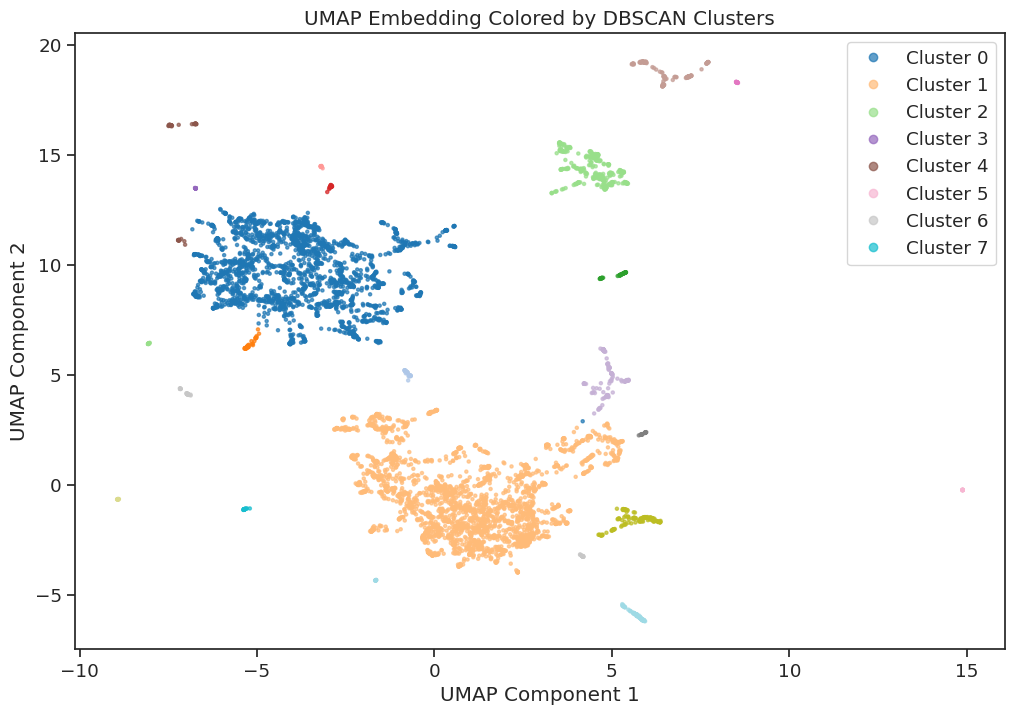

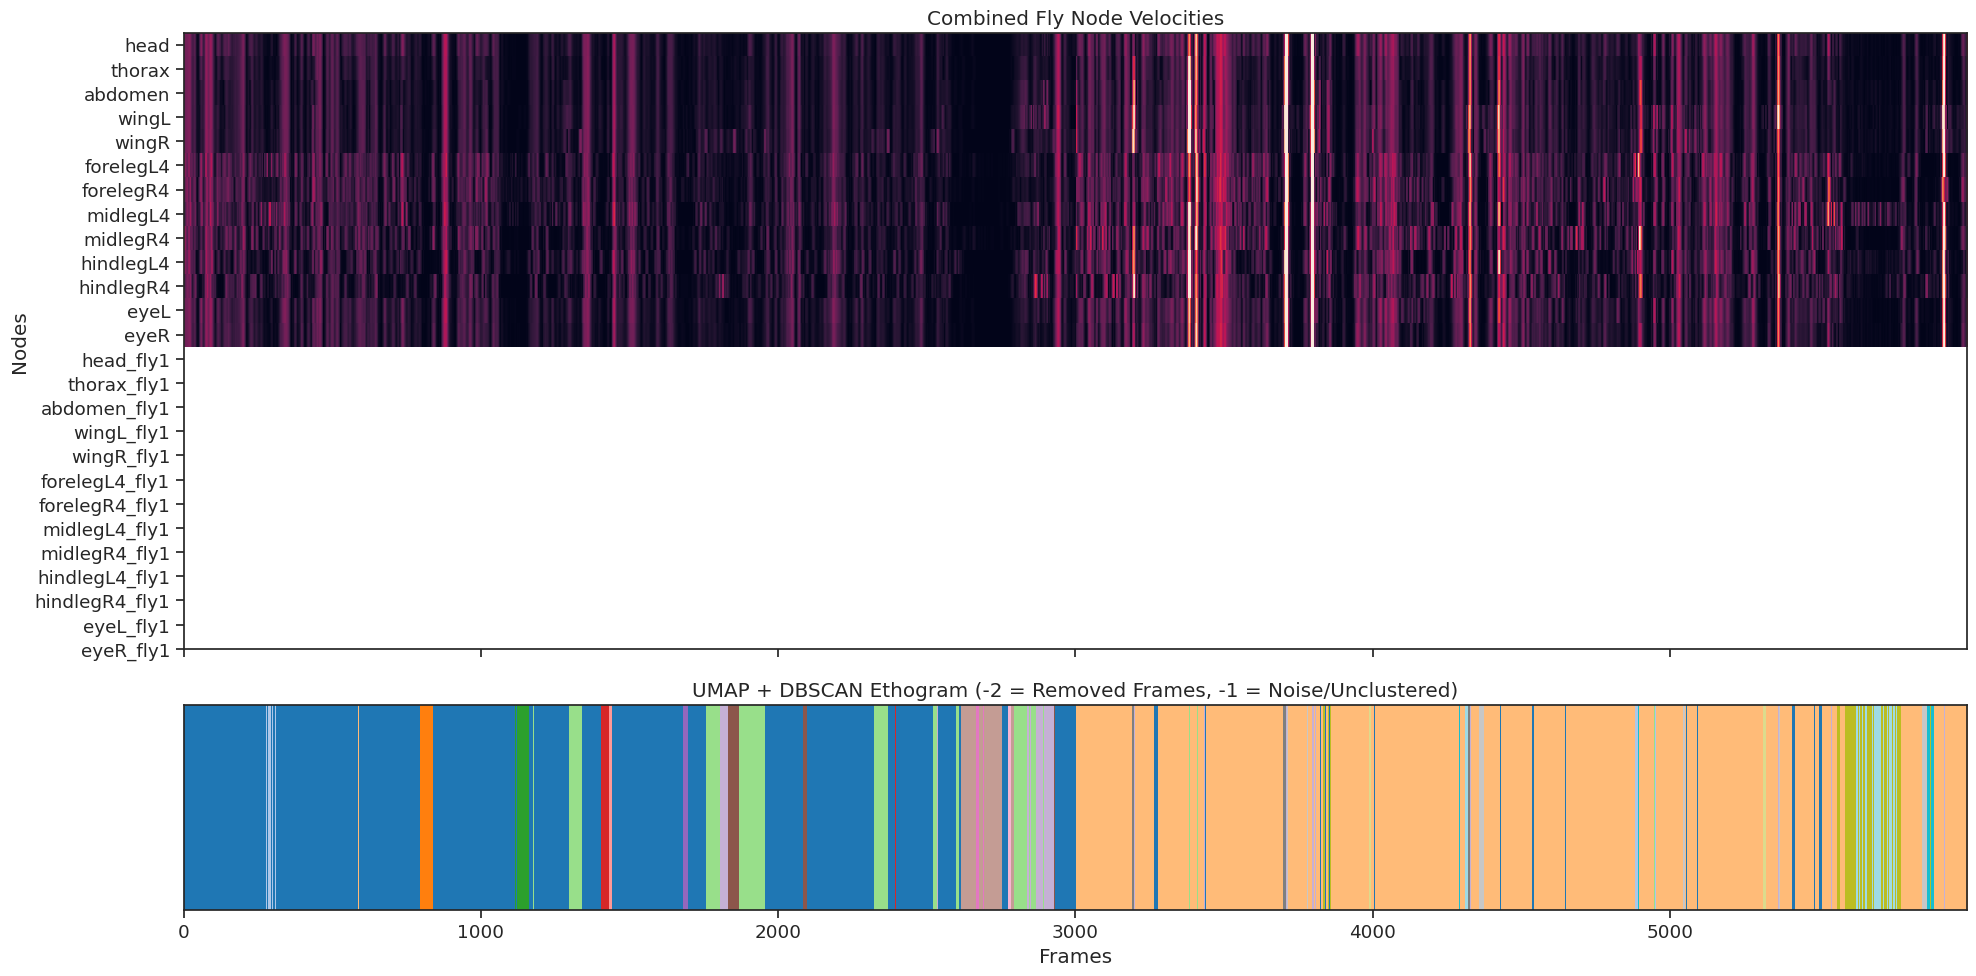

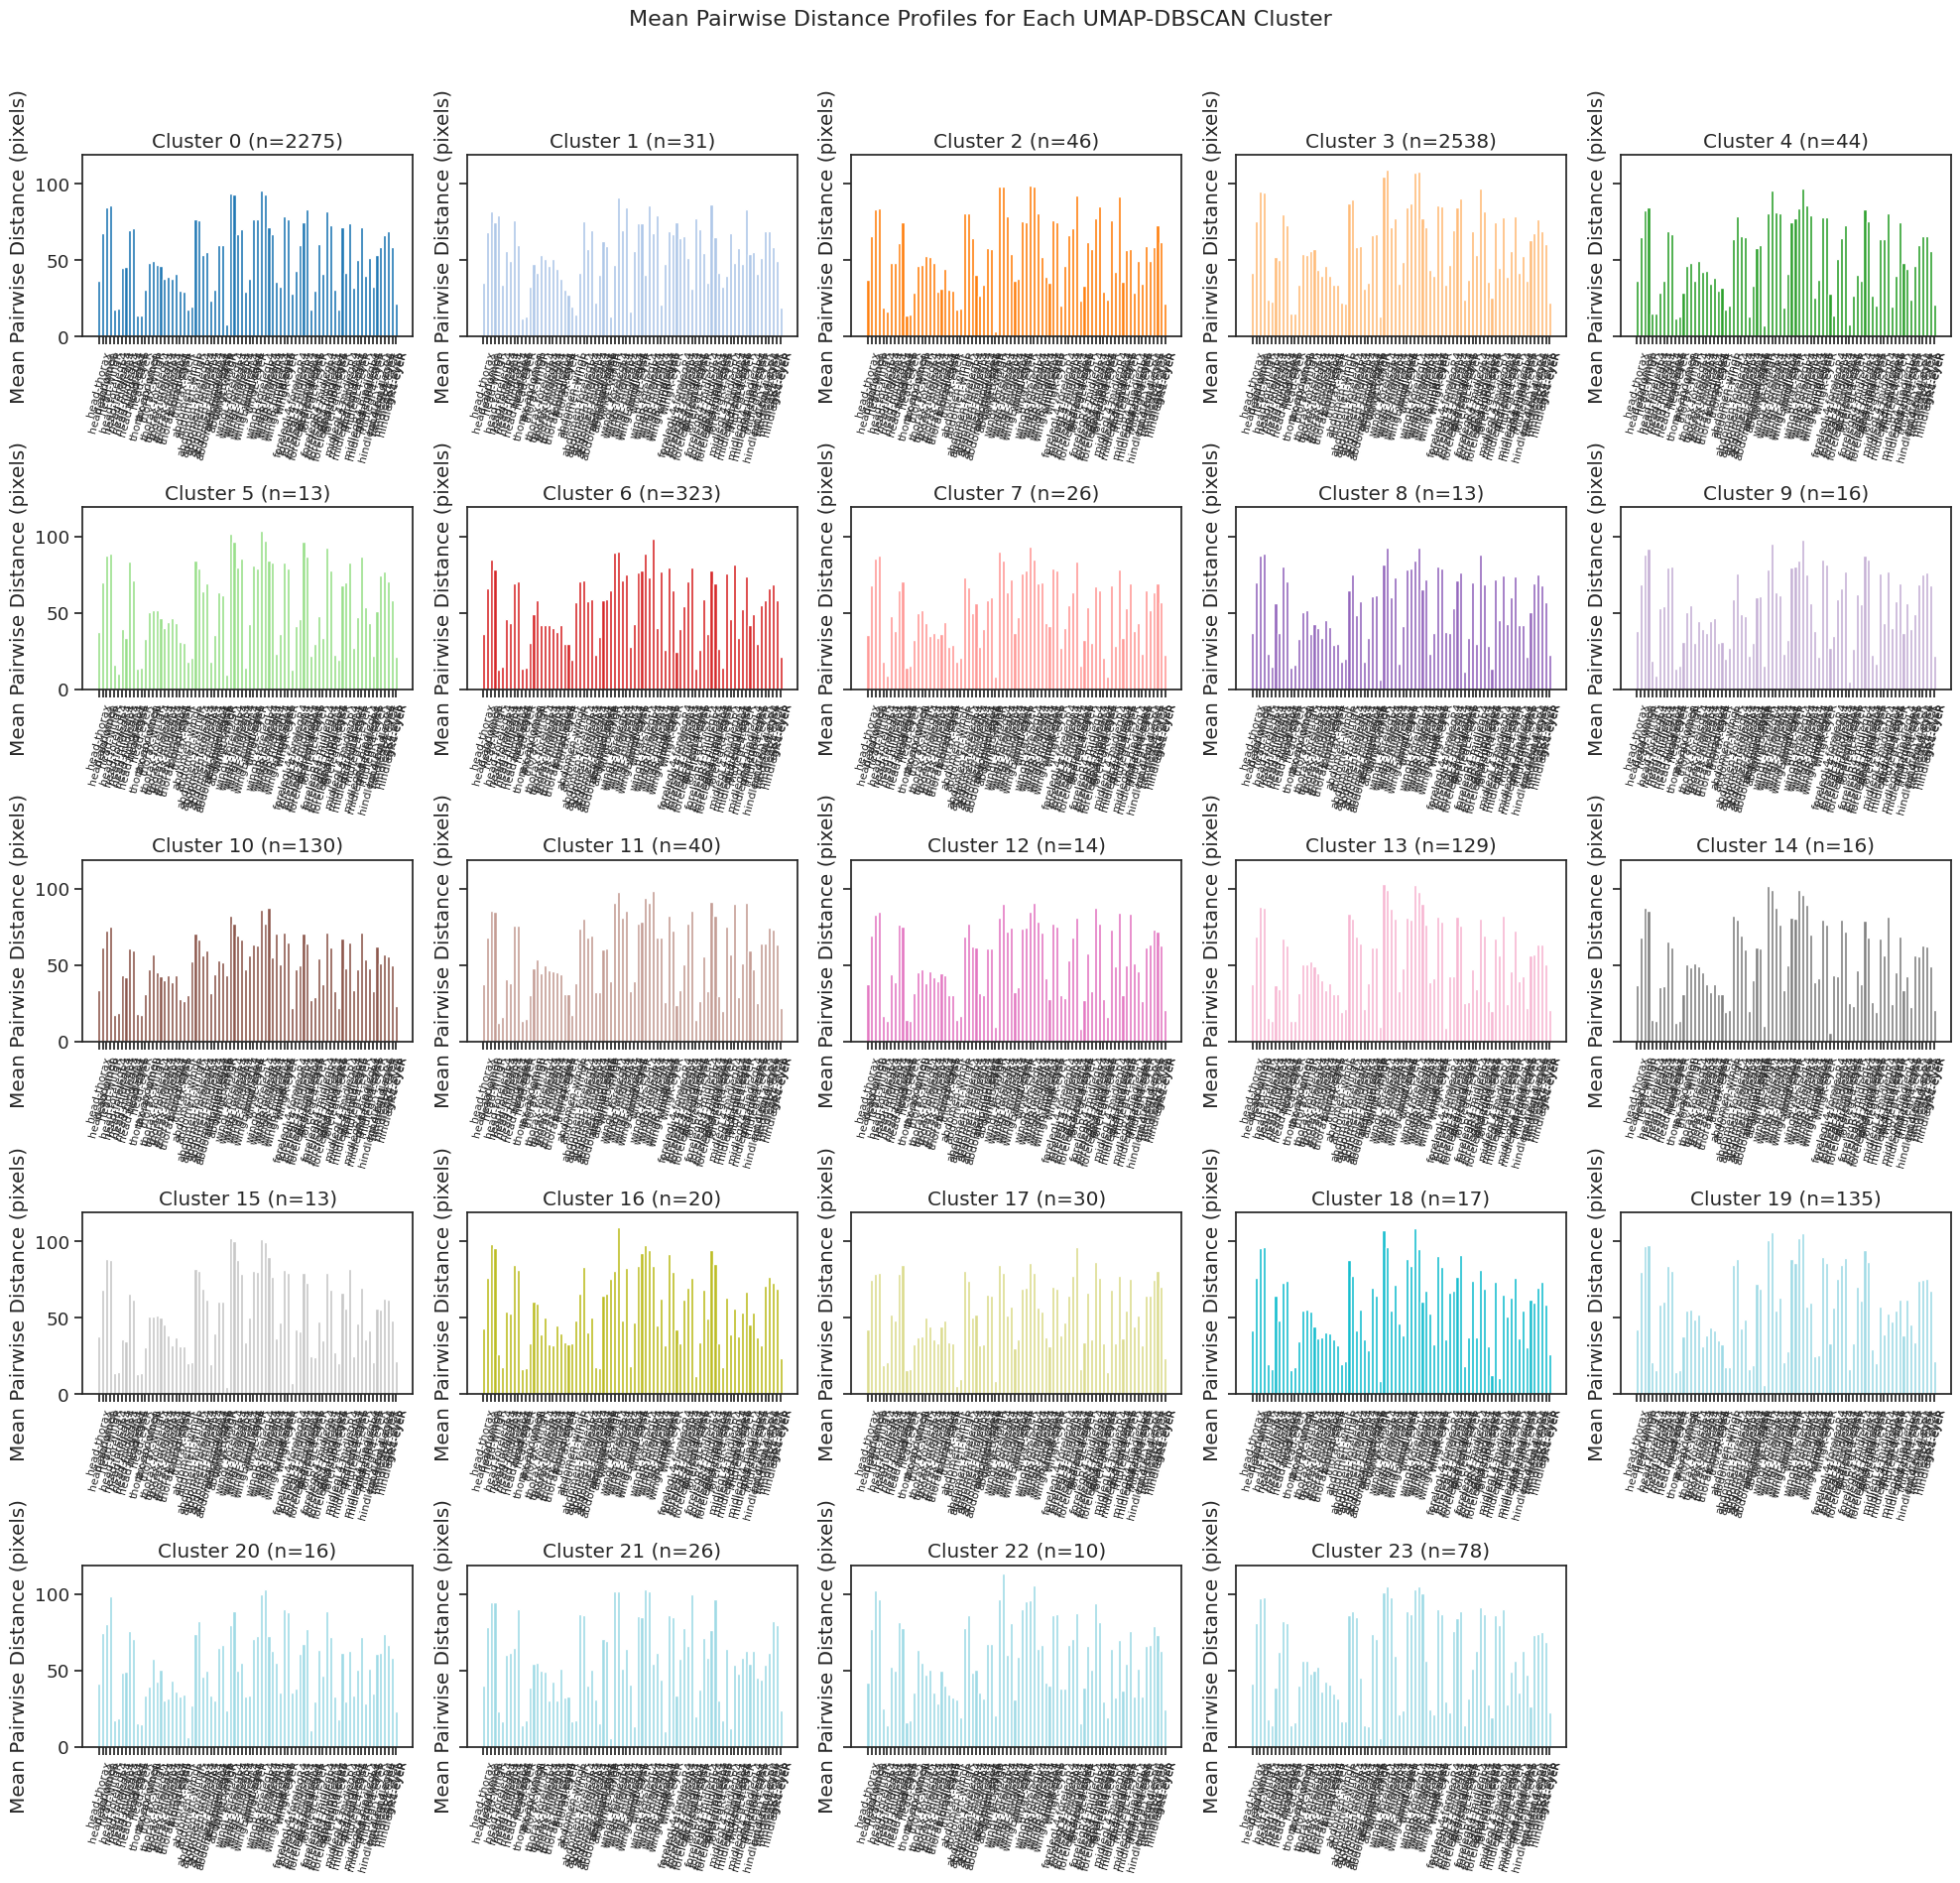

In [31]:
import umap.umap_ as umap
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Handle Missing Values and Scale the Data ---
# Ensure data is in the shape (frames, features).
if pairwise_distances.shape[0] < pairwise_distances.shape[1]:
    pairwise_distances = pairwise_distances.T

# Explicitly handle missing values in pairwise_distances before scaling
# Interpolate within columns
pairwise_distances_filled = pairwise_distances.copy()
for col in range(pairwise_distances_filled.shape[1]):
    nan_indices = np.isnan(pairwise_distances_filled[:, col])
    if np.any(nan_indices):
        # Interpolate non-NaN values
        valid_indices = np.flatnonzero(~nan_indices)
        if len(valid_indices) > 1:
            interpolator = interp1d(valid_indices, pairwise_distances_filled[valid_indices, col], kind='linear', fill_value="extrapolate")
            pairwise_distances_filled[nan_indices, col] = interpolator(np.flatnonzero(nan_indices))
        elif len(valid_indices) == 1:
             # Fill with the single valid value if only one exists
             pairwise_distances_filled[nan_indices, col] = pairwise_distances_filled[valid_indices, col]
        # Handle remaining NaNs at the boundaries after extrapolation
        pairwise_distances_filled[:, col] = np.nan_to_num(pairwise_distances_filled[:, col], nan=np.nanmean(pairwise_distances_filled[:, col]), posinf=np.nanmean(pairwise_distances_filled[:, col]), neginf=np.nanmean(pairwise_distances_filled[:, col]))


# Remove any rows that still contain NaNs or infinite values after interpolation
valid_indices = np.isfinite(pairwise_distances_filled).all(axis=1)
cleaned_pairwise_distances = pairwise_distances_filled[valid_indices]
original_indices = np.arange(pairwise_distances_filled.shape[0])[valid_indices]


if cleaned_pairwise_distances.shape[0] == 0:
    print("Error: No valid data remaining after removing NaNs/Infinities.")
else:
    # Scale the data before applying UMAP.
    scaler = StandardScaler()
    scaled_distances = scaler.fit_transform(cleaned_pairwise_distances)

    # --- 2. Apply UMAP for Dimensionality Reduction ---
    # n_neighbors: Balances local vs. global structure. Larger values look at more global structure.
    # min_dist: Controls how tightly UMAP packs points together.
    # metric: 'euclidean' is a standard choice for general-purpose feature vectors.
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=123, metric="euclidean")
    embedding = reducer.fit_transform(scaled_distances)


    # --- 3. Cluster the Embedding with DBSCAN ---
    # DBSCAN groups together points that are closely packed together, marking as outliers
    # points that lie alone in low-density regions.
    # eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    # min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
    # These parameters may require tuning for optimal results.
    dbscan = DBSCAN(eps=0.5, min_samples=10) # Adjust eps based on UMAP embedding density
    umap_labels_cleaned = dbscan.fit_predict(embedding)

    n_clusters_found = len(set(umap_labels_cleaned)) - (1 if -1 in umap_labels_cleaned else 0)
    print(f"DBSCAN found {n_clusters_found} distinct clusters (plus noise labeled as -1).")


    # --- 4. Visualize the Clustered UMAP Embedding ---
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=umap_labels_cleaned, cmap='tab20', s=5, alpha=0.7)
    plt.title("UMAP Embedding Colored by DBSCAN Clusters")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")

    # Create a legend for the found clusters
    handles, _ = scatter.legend_elements()
    cluster_labels_for_legend = [f'Cluster {i}' for i in np.unique(umap_labels_cleaned) if i != -1]
    if -1 in np.unique(umap_labels_cleaned):
        cluster_labels_for_legend.append('Noise')
    plt.legend(handles, cluster_labels_for_legend)
    plt.show()


    # --- 5. Ethogram and Cluster Interpretation ---

    # Create a full label array including the removed frames
    umap_labels = np.full(pairwise_distances.shape[0], -2, dtype=int) # Use -2 for removed frames based on original shape
    umap_labels[original_indices] = umap_labels_cleaned


    # Ethogram showing the sequence of behaviors over time
    fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Use the combined fly_node_velocities for the ethogram visualization
    axs[0].imshow(np.hstack((fly_node_velocities0.T, fly_node_velocities1.T)), aspect="auto", vmin=0, vmax=20, interpolation="nearest")
    axs[0].set_ylabel("Nodes")
    # Create combined node labels for the ethogram
    combined_node_names_ethogram = node_names + [f'{name}_fly1' for name in node_names]
    axs[0].set_yticks(np.arange(len(combined_node_names_ethogram)))
    axs[0].set_yticklabels(combined_node_names_ethogram)
    axs[0].set_title("Combined Fly Node Velocities")

    axs[1].imshow(umap_labels[None, :], aspect="auto", cmap="tab20", interpolation="nearest")
    axs[1].set_xlabel("Frames")
    axs[1].set_yticks([])
    axs[1].set_title("UMAP + DBSCAN Ethogram (-2 = Removed Frames, -1 = Noise/Unclustered)")
    plt.tight_layout()
    plt.show()

    # Mean Velocity Profiles for each cluster
    positive_labels = sorted([l for l in np.unique(umap_labels_cleaned) if l != -1])
    n_clusters = len(positive_labels)
    n_cols = 5
    n_rows = int(np.ceil(n_clusters / n_cols)) if n_cols > 0 else 0

    if n_rows > 0:
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharey=True)
        axs = axs.ravel()

        for i, cluster_id in enumerate(positive_labels):
            # Find frames belonging to this cluster in the *original* data
            cluster_frames_indices = original_indices[umap_labels_cleaned == cluster_id]
            # Use the filled pairwise distances for mean profile calculation
            cluster_frames_distances = cleaned_pairwise_distances[umap_labels_cleaned == cluster_id]


            if len(cluster_frames_distances) > 0:
                # Calculate the mean pairwise distance profile
                mean_profile = cluster_frames_distances.mean(axis=0)

                # Plot the profile as a bar chart using all feature labels
                axs[i].bar(feature_labels, mean_profile, color=plt.cm.tab20(cluster_id))
                axs[i].set_title(f"Cluster {cluster_id} (n={len(cluster_frames_distances)})")
                axs[i].tick_params(axis='x', rotation=75, labelsize=8)
                axs[i].set_ylabel("Mean Pairwise Distance (pixels)")

        # Hide any unused subplots
        for j in range(i + 1, len(axs)):
            axs[j].set_visible(False)

        fig.suptitle("Mean Pairwise Distance Profiles for Each UMAP-DBSCAN Cluster", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

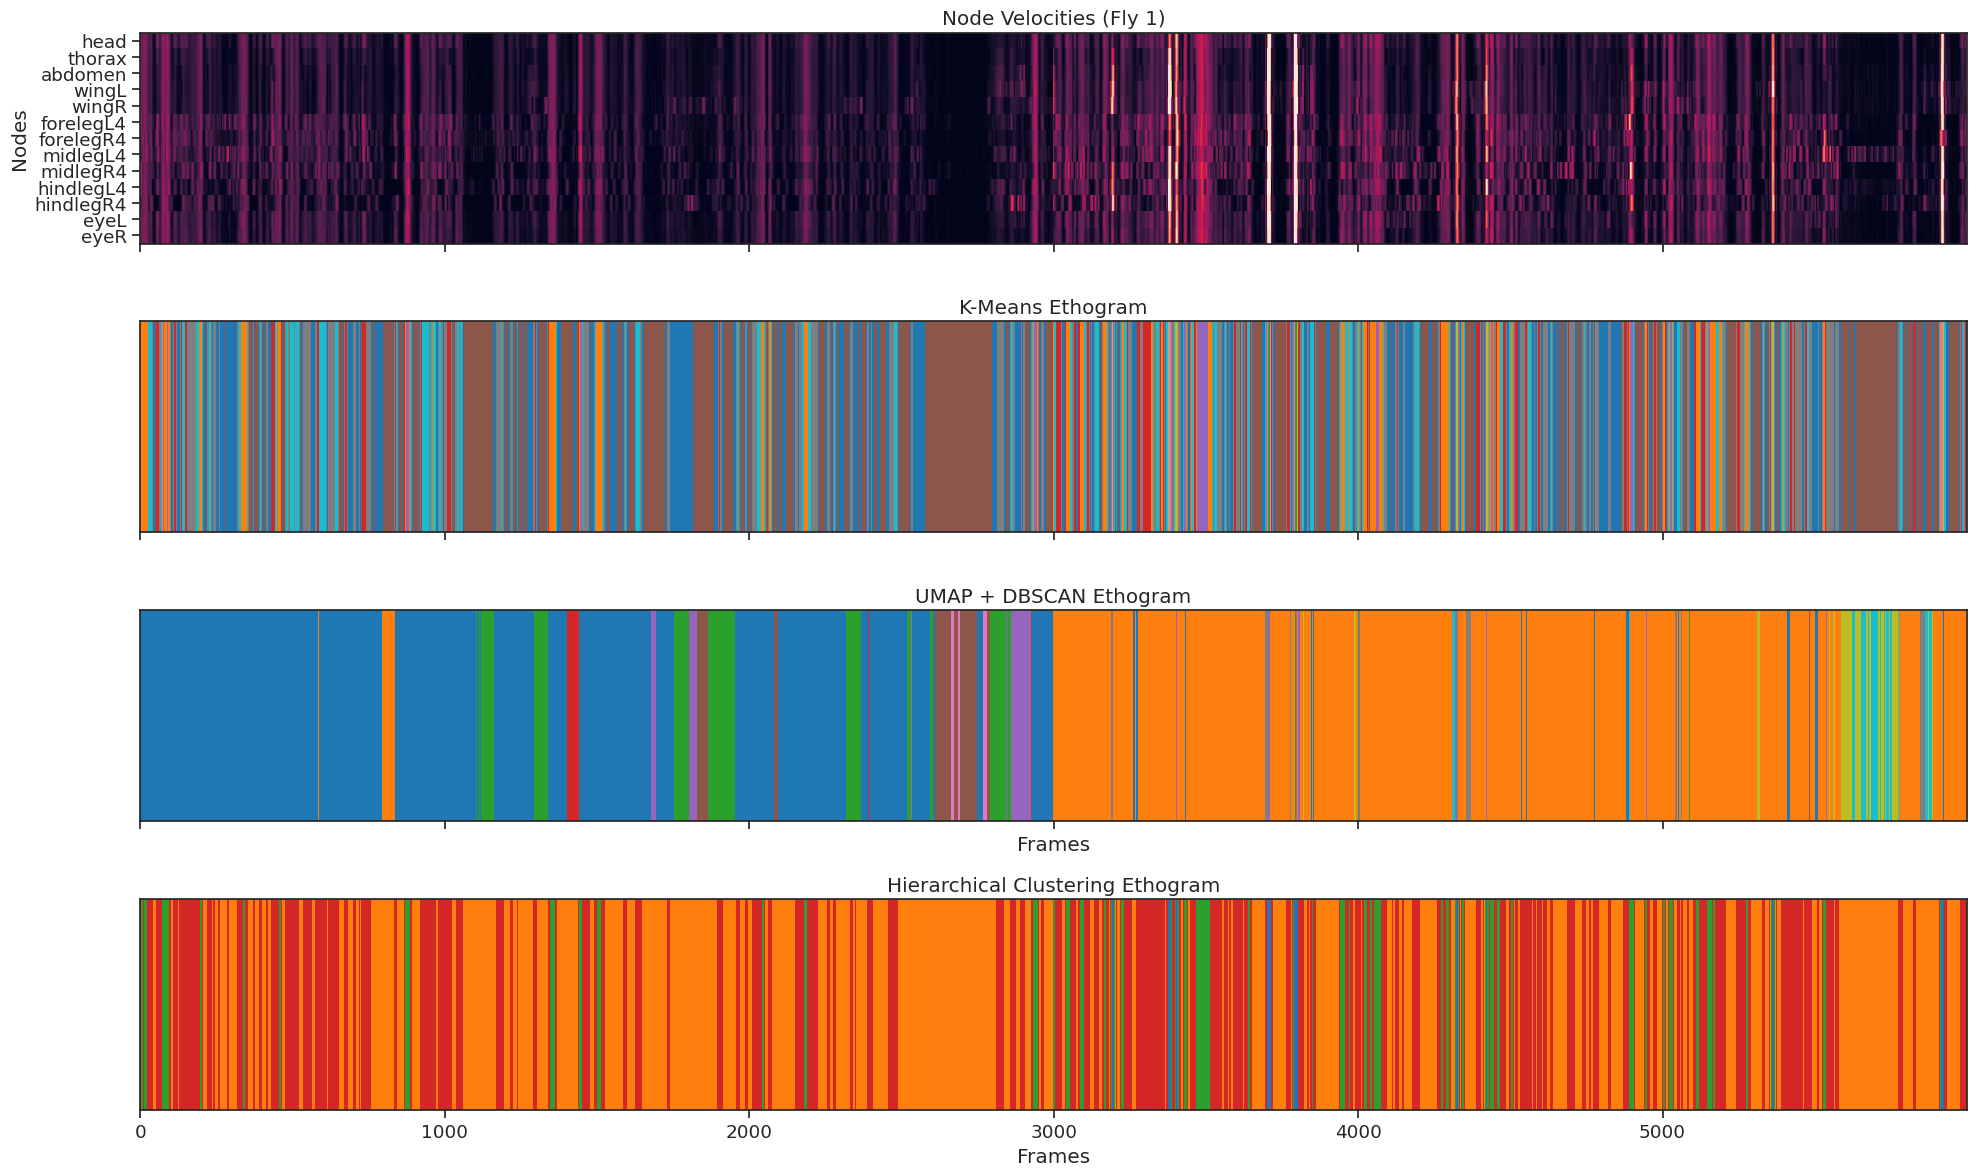

In [50]:
fig, axs = plt.subplots(4, 1, figsize=(20, 12), sharex=True)

axs[0].imshow(fly_node_velocities, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
axs[0].set_title('Node Velocities (Fly 1)')
axs[0].set_ylabel('Nodes')
axs[0].set_yticks(np.arange(node_count))
axs[0].set_yticklabels(node_names)

axs[1].imshow(klabels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
axs[1].set_title('K-Means Ethogram')
axs[1].set_yticks([])

# For DBSCAN, map -1 to a neutral color if needed (tab10 handles negative as gray)
axs[2].imshow(umap_labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
axs[2].set_title('UMAP + DBSCAN Ethogram')
axs[2].set_yticks([])
axs[2].set_xlabel('Frames')

axs[3].imshow(hierarchical_labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest", vmin=1, vmax=n_clusters)
axs[3].set_xlabel("Frames")
axs[3].set_yticks([])
axs[3].set_title("Hierarchical Clustering Ethogram");

plt.tight_layout()
plt.show()

# Supervised Machine Learning for Behavior Classification

Here, we'll create simple labels for our data ("locomotion" vs. "stationary") and train classifiers to predict these labels from the velocity features.

## Label Generation
We'll define "locomotion" as any moment where the fly's thorax is moving above a certain speed. This creates a binary classification problem

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Use thorax velocity (a key indicator of overall movement)
thorax_index = [i for i, name in enumerate(node_names) if name == 'thorax'][0]
thorax_velocity = fly_node_velocities[:, thorax_index]

# Create labels: 1 for locomotion, 0 for stationary
velocity_threshold = 5
labels = (thorax_velocity > velocity_threshold).astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    fly_node_velocities, labels, test_size=0.3, random_state=42, stratify=labels
)

print(f"Training set size: {X_train.shape[0]} frames")
print(f"Testing set size: {X_test.shape[0]} frames")
print(f"Locomotion vs. Stationary split: {np.bincount(labels)}")

Training set size: 4200 frames
Testing set size: 1800 frames
Locomotion vs. Stationary split: [5335  665]


## Support Vector Machine (SVM)
SVMs are effective classifiers that find the optimal hyperplane to separate different classes in the feature space.

In [36]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# SVMs are sensitive to feature scaling, so we use a pipeline
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto'))
svm_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_svm = svm_model.predict(X_test)
print("--- SVM Classification Report ---")
print(accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=['Stationary', 'Locomotion']))



--- SVM Classification Report ---
0.9938888888888889
              precision    recall  f1-score   support

  Stationary       1.00      1.00      1.00      1601
  Locomotion       0.97      0.97      0.97       199

    accuracy                           0.99      1800
   macro avg       0.99      0.98      0.98      1800
weighted avg       0.99      0.99      0.99      1800



## Random Forest

Random Forests are an ensemble method that builds multiple decision trees and aggregates their predictions, making them robust and less prone to overfitting.


In [57]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_rf = rf_model.predict(X_test)
print("--- Random Forest Classification Report ---")
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=['Stationary', 'Locomotion']))

--- Random Forest Classification Report ---
0.9994444444444445
              precision    recall  f1-score   support

  Stationary       1.00      1.00      1.00      1601
  Locomotion       1.00      0.99      1.00       199

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



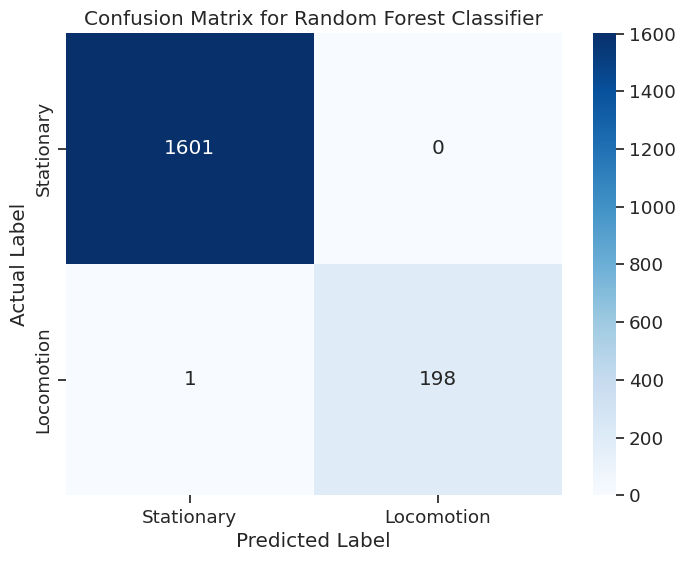

In [58]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stationary', 'Locomotion'],
            yticklabels=['Stationary', 'Locomotion'])
plt.title('Confusion Matrix for Random Forest Classifier')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

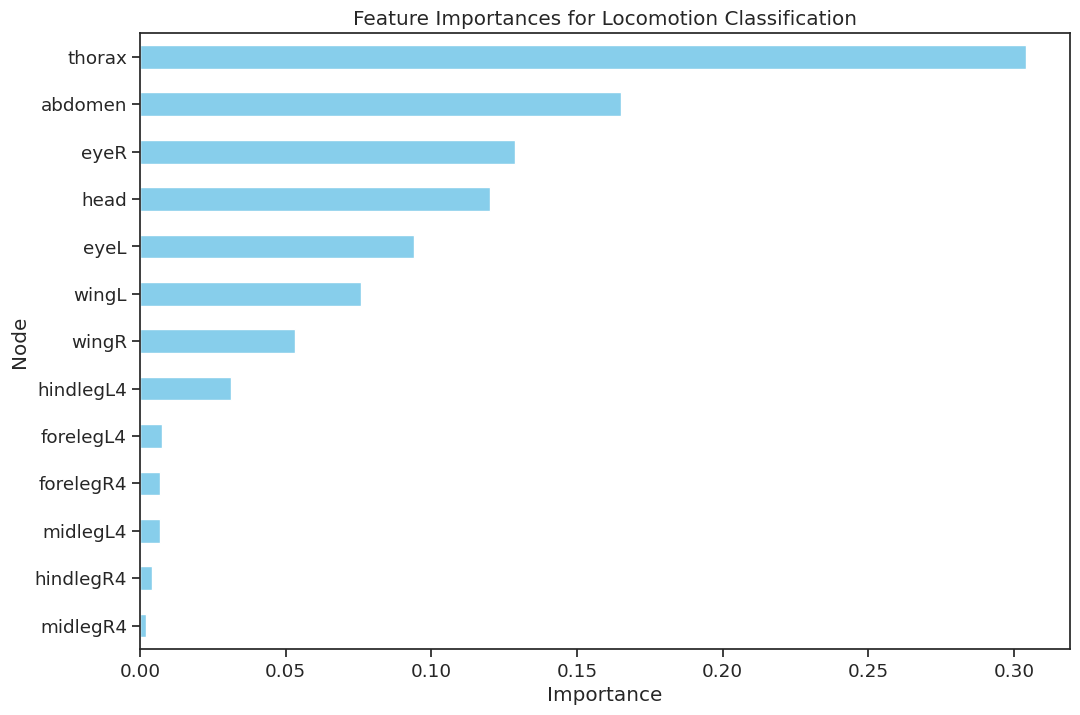

In [59]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = node_names  # Since we used the same features for both flies

# Create a pandas series for easier plotting
importance_series = pd.Series(importances, index=feature_names)

# Plot the feature importances
plt.figure(figsize=(12, 8))
importance_series.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Importances for Locomotion Classification')
plt.xlabel('Importance')
plt.ylabel('Node')
plt.show()

## XGBoost (eXtreme Gradient Boosting)
XGBoost is a highly efficient and powerful implementation of gradient boosting, another ensemble technique. It's often a top performer in machine learning competitions

In [38]:
import xgboost as xgb

# Create and train the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_xgb = xgb_model.predict(X_test)
print("--- XGBoost Classification Report ---")
print(accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=['Stationary', 'Locomotion']))

--- XGBoost Classification Report ---
0.9977777777777778
              precision    recall  f1-score   support

  Stationary       1.00      1.00      1.00      1601
  Locomotion       0.99      0.99      0.99       199

    accuracy                           1.00      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       1.00      1.00      1.00      1800



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:20:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Covariance between subjects

In [ ]:
def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between

    win sets the number of frames over which the covariance is computed

    """

    s1 = pd.Series(datax)
    s2 = pd.Series(datay)

    return np.array(s2.rolling(win).corr(s1))

In [ ]:
win = 50

cov_vel = corr_roll(thx_vel_fly0, thx_vel_fly1,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_fly0, 'y', label='fly-0')
ax[0].plot(thx_vel_fly1, 'g', label='fly-1')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()